In [ ]:
import numpy as np
import astropy
from astropy.io import ascii
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from matplotlib.colors import LogNorm
from astropy.table import join
import all_fctns

def refresh_module():
    import importlib
    import all_fctns
    importlib.reload(all_fctns)


Source_dir ="C:\\Users\\mspan\\OneDrive - The University of Sydney (Students)\\Honours\\"

SAMI_regions = ("Cluster", "Filler", "GAMA")
SAMI_Target_catalogues = ("InputCatClustersDR3.fits", "InputCatFiller.fits", "InputCatGAMADR3.fits")

crossmatching_catalogues = ("RACS-mid1_sources.fits", "LARGESS.fits", "eRASS1_Main.v1.1.fits")

def angular_dist(r1, d1, r2, d2):    
    a = np.sin(np.abs(d1 - d2)/2)**2
    b = np.cos(d1)*np.cos(d2)*np.sin(np.abs(r1 - r2)/2)**2
    
    d_rad = 2*np.arcsin((a+b)**(1/2))
    d_deg = np.degrees(d_rad)
    return d_deg

def get_RA_Dec_cutout_fits_table(table_hdu: Table, bounds: tuple, bound_type = 'rect', col_names = ('RA', 'Dec')):
    
    if bound_type == 'rect':
        # Get rid of all not within RA range
        RA_array = np.array(table_hdu[col_names[0]])
        sort_ind_RA_removed = (RA_array > bounds[0][0]) & (RA_array < bounds[1][0] )
        table_hdu_RA_removed = table_hdu[sort_ind_RA_removed]


        # Get rid of all values not within Dec range
        Dec_array = np.array(table_hdu_RA_removed[col_names[1]])
        sort_ind_both_removed = (Dec_array > bounds[0][1]) & (Dec_array < bounds[1][1] )
        table_hdu_both_removed = table_hdu_RA_removed[sort_ind_both_removed]
    
    elif bound_type == 'circ': # need to convert degrees to radians for np.sin and np.cos
        RA_array = np.array(table_hdu[col_names[0]]) * np.pi/180
        Dec_array = np.array(table_hdu[col_names[1]]) * np.pi/180

        r_bound = bounds[1]
        circle_centre_RA = bounds[0][0] * np.pi/180
        circle_centre_Dec = bounds[0][1] * np.pi/180

        mask_within_radius = angular_dist(RA_array, Dec_array, circle_centre_RA, circle_centre_Dec) < r_bound
        table_hdu_both_removed = table_hdu[mask_within_radius]

    else:
        raise TypeError(f"Invalid bound type: {bound_type}. Valid types are \'rect\' and \'circ\'")

    return table_hdu_both_removed

def get_fits_table_SAMI_target_regions_cutout(fits_filepath, fits_filename, col_names, save_file = True):

    GAMA_region_bounds = [((129,-2), (141, 3)), ((174, -3), (186, 2)), ((211.5, -2), (223.5, 3))] # bounds of the GAMA target regions in the SAMI data including filler which are rectangular in shape (bottom left to top right coords) all in degrees

    Cluster_region_bounds = [((355.397880, -29.236351), 2), ((18.815777, 0.213486), 1.5), ((18.739974, 0.430807), 1), 
                            ((356.937810, -28.140661), 3), ((6.380680, -33.046570), 1.5), ((336.977050, -30.575371), 2), 
                            ((329.372605, -7.795692), 2), ((14.067150, -1.255370), 2), ((10.460211, -9.303184), 3)] # bounds of the Cluster target regions (including filler targets) circular in shape  ((x_centre,y_centre), r_approx) all in degrees


    with fits.open(fits_filepath+fits_filename) as hdul:
        cutout_tables = []

        table_hdu = Table(hdul[1].data)


        bound_type = 'rect'

        for bounds in GAMA_region_bounds:
            table_hdu_both_cutout = get_RA_Dec_cutout_fits_table(table_hdu, bounds, bound_type=bound_type, col_names=col_names)
            cutout_tables.append(table_hdu_both_cutout)


        bound_type = 'circ'

        for bounds in Cluster_region_bounds:
            table_hdu_both_cutout = get_RA_Dec_cutout_fits_table(table_hdu, bounds, bound_type=bound_type, col_names=col_names)
            cutout_tables.append(table_hdu_both_cutout)
  

    table_hdu_allcutouts = astropy.table.vstack(cutout_tables) # stack tables together
    unique_table_hdu_allcutouts = astropy.table.unique(table_hdu_allcutouts) # remove duplicates created from vstacking

    if save_file:
        unique_table_hdu_allcutouts.write(fits_filepath+"SAMI_target_region_cutout_"+fits_filename)
        savepath = str(fits_filepath+"SAMI_target_regions_cutout_"+fits_filename)
        print(f"Cutout saved to {savepath}")

    return unique_table_hdu_allcutouts

def get_crossmatched_fits_table(fits_filepath, SAMI_Target_catalogue, crossmatching_catalogue, sep_arcsec = 20, crossmatching_colnames = ('RA', 'Dec'), separation_column = True, save_file = True):
    """
    Returns and Saves a crossmatched catalogue of a SAMI_Target_catalogue and the desired crossmatching_catalogue when separation of objects is less than sep_arcsec.
    """

    max_separation = sep_arcsec  /3600 #max distance to be considered a match in arcsec (converted to degrees by /3600)

    try: # test if a cutout exists
        with fits.open(fits_filepath + "SAMI_target_region_cutout_" + crossmatching_catalogue) as crossmatching_hdul:
            None
    except FileNotFoundError:
        print("SAMI Target Region Cutout does not already exist.")
        get_fits_table_SAMI_target_regions_cutout(fits_filepath, crossmatching_catalogue, col_names=crossmatching_colnames)



    with fits.open(fits_filepath + SAMI_Target_catalogue) as SAMI_Target_hdul, fits.open(fits_filepath + "SAMI_target_region_cutout_" + crossmatching_catalogue) as crossmatching_hdul:
        
        SAMI_Target_table_hdu = Table(SAMI_Target_hdul[1].data)

        SAMI_table_headers = SAMI_Target_table_hdu.columns
        SAMI_RA_array = np.array(SAMI_Target_table_hdu['RA_OBJ'])
        SAMI_Dec_array = np.array(SAMI_Target_table_hdu['DEC_OBJ'])

        SAMI_RA_array_rad = np.deg2rad(SAMI_RA_array)
        SAMI_Dec_array_rad = np.deg2rad(SAMI_Dec_array)

        crossmatching_table_hdu = Table(crossmatching_hdul[1].data)
        
        crossmatching_table_headers = crossmatching_table_hdu.columns
        crossmatching_RA_array = np.array(crossmatching_table_hdu[crossmatching_colnames[0]])
        crossmatching_Dec_array = np.array(crossmatching_table_hdu[crossmatching_colnames[1]])
    # print(SAMI_table_headers +crossmatching_table_headers)

        crossmatching_RA_array_rad = np.deg2rad(crossmatching_RA_array)
        crossmatching_Dec_array_rad = np.deg2rad(crossmatching_Dec_array)


        #crossmatched_table = astropy.table.hstack([SAMI_table_headers, crossmatching_table_headers])
        #print(crossmatched_table)
        #crossmatched_table.remove_row(0) # needed for some reason

        #if separation_column:
        #    print(crossmatched_table)
        #    crossmatched_table.add_column(astropy.table.Column(name='separation'))
        #crossmatched_table.update(crossmatching_table_headers)

        no_matches_yet = True

        for j in range(len(SAMI_RA_array)):
            SAMI_RA = SAMI_RA_array_rad[j]
            SAMI_Dec =SAMI_Dec_array_rad[j]

            separations = angular_dist(crossmatching_RA_array_rad, crossmatching_Dec_array_rad, SAMI_RA, SAMI_Dec)

            mask_separation = separations < max_separation

            num_matches = np.sum(mask_separation)

            if num_matches >0:

                crossmatched_rows = Table(crossmatching_table_hdu[mask_separation])  #get a table of only the matched rows
                if separation_column:
                    crossmatched_rows.add_column(astropy.table.Column(separations[mask_separation]*3600, name='separation', unit='arcsec'))  # add separation column (in arcseconds)

                # now need to setup table with num_matches number of rows of the original SAMI table row

                SAMI_repeats_rows = Table( np.repeat(SAMI_Target_table_hdu[j], num_matches), names=SAMI_table_headers )

                specific_crossmatched_table = astropy.table.hstack([SAMI_repeats_rows, crossmatched_rows], join_type='outer')

                # add matches for specific SAMI object to crossmatched_table
                if no_matches_yet:
                    no_matches_yet = False
                    crossmatched_table = specific_crossmatched_table

                else:
                    crossmatched_table = astropy.table.vstack([crossmatched_table, specific_crossmatched_table])
            
        
        if save_file:
            crossmatched_filename = f"{SAMI_Target_catalogue[:-5]}_matched_{crossmatching_catalogue}"

            crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename
            crossmatched_table.write(crossmatched_filepath)
            print(f"Crossmatched Table Saved to: {crossmatched_filepath}")

    return crossmatched_table
    
def get_all_SAMI_crossmatched_fits_table(catalogues_filepath, crossmatching_catalogue, sep_arcsec = 20, crossmatching_colnames = ('RA', 'Dec'), separation_column = True, save_file = True):
    SAMI_Target_catalogues = ("InputCatClustersDR3.fits", "InputCatFiller.fits", "InputCatGAMADR3.fits")
    SAMI_regions = ("Cluster", "Filler", "GAMA")

    crossmatched_tables = []

    for k, SAMI_Target_catalogue in enumerate(SAMI_Target_catalogues):
        crossmatched_table = get_crossmatched_fits_table(catalogues_filepath, SAMI_Target_catalogue, crossmatching_catalogue, save_file=False, sep_arcsec=sep_arcsec, crossmatching_colnames=crossmatching_colnames, separation_column=separation_column)

        crossmatched_table.add_column(astropy.table.Column([SAMI_regions[k]]*len(crossmatched_table), name='SAMI_region'))

        crossmatched_tables.append(crossmatched_table)

    all_SAMI_crossmatched_table = astropy.table.vstack(crossmatched_tables)

    if save_file:
        crossmatched_filename = f"all_SAMI_target_matched_{crossmatching_catalogue}"

        crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename
        all_SAMI_crossmatched_table.write(crossmatched_filepath)
        print(f"Crossmatched Table Saved to: {crossmatched_filepath}")


    return all_SAMI_crossmatched_table



# Getting cutouts

In [9]:
# testing a cutout of 09h Gamma Region

input_files = ["RACS-mid1_components.fits", "RACS-mid1_sources.fits"]
input_files1 = "RACS-mid1_components.fits"

def get_RA_Dec_cutout_fits_table(table_hdu: Table, bounds: tuple, bound_type = 'rect', col_names = ('RA', 'Dec')):
    
    if bound_type == 'rect':
        # Get rid of all not within RA range
        RA_array = np.array(table_hdu[col_names[0]])
        sort_ind_RA_removed = (RA_array > bounds[0][0]) & (RA_array < bounds[1][0] )
        table_hdu_RA_removed = table_hdu[sort_ind_RA_removed]


        # Get rid of all values not within Dec range
        Dec_array = np.array(table_hdu_RA_removed[col_names[1]])
        sort_ind_both_removed = (Dec_array > bounds[0][1]) & (Dec_array < bounds[1][1] )
        table_hdu_both_removed = table_hdu_RA_removed[sort_ind_both_removed]
    
    elif bound_type == 'circ': # need to convert degrees to radians for np.sin and np.cos
        RA_array = np.array(table_hdu[col_names[0]]) * np.pi/180
        Dec_array = np.array(table_hdu[col_names[1]]) * np.pi/180

        r_bound = bounds[1]
        circle_centre_RA = bounds[0][0] * np.pi/180
        circle_centre_Dec = bounds[0][1] * np.pi/180

        mask_within_radius = angular_dist(RA_array, Dec_array, circle_centre_RA, circle_centre_Dec) < r_bound
        table_hdu_both_removed = table_hdu[mask_within_radius]

    else:
        raise TypeError(f"Invalid bound type: {bound_type}. Valid types are \'rect\' and \'circ\'")

    return table_hdu_both_removed

def get_fits_table_SAMI_target_regions_cutout(fits_filepath, fits_filename, col_names, save_file = True):

    GAMA_region_bounds = [((129,-2), (141, 3)), ((174, -3), (186, 2)), ((211.5, -2), (223.5, 3))] # bounds of the GAMA target regions in the SAMI data including filler which are rectangular in shape (bottom left to top right coords) all in degrees

    Cluster_region_bounds = [((355.397880, -29.236351), 2), ((18.815777, 0.213486), 1.5), ((18.739974, 0.430807), 1), 
                            ((356.937810, -28.140661), 3), ((6.380680, -33.046570), 1.5), ((336.977050, -30.575371), 2), 
                            ((329.372605, -7.795692), 2), ((14.067150, -1.255370), 2), ((10.460211, -9.303184), 3)] # bounds of the Cluster target regions (including filler targets) circular in shape  ((x_centre,y_centre), r_approx) all in degrees


    with fits.open(fits_filepath+fits_filename) as hdul:
        cutout_tables = []

        table_hdu = Table(hdul[1].data)


        bound_type = 'rect'

        for bounds in GAMA_region_bounds:
            table_hdu_both_cutout = get_RA_Dec_cutout_fits_table(table_hdu, bounds, bound_type=bound_type)
            cutout_tables.append(table_hdu_both_cutout)


        bound_type = 'circ'

        for bounds in Cluster_region_bounds:
            table_hdu_both_cutout = get_RA_Dec_cutout_fits_table(table_hdu, bounds, bound_type=bound_type)
            cutout_tables.append(table_hdu_both_cutout)
  

    table_hdu_allcutouts = astropy.table.vstack(cutout_tables) # stack tables together
    unique_table_hdu_allcutouts = astropy.table.unique(table_hdu_allcutouts) # remove duplicates created from vstacking

    if save_file:
        unique_table_hdu_allcutouts.write(fits_filepath+"SAMI_target_region_cutout_"+fits_filename)
        savepath = str(fits_filepath+"SAMI_target_regions_cutout_"+fits_filename)
        print(f"Cutout saved to {savepath}")

    return unique_table_hdu_allcutouts

fits_filename = "RACS-mid1_sources.fits"
fits_filepath = Source_dir+"Catalogues\\"

hdul_test = get_fits_table_SAMI_target_regions_cutout(fits_filepath, fits_filename)

TypeError: get_fits_table_SAMI_target_regions_cutout() missing 1 required positional argument: 'col_names'

In [10]:
""" Used to test the circular cutout function
"""
input_files = ["RACS-mid1_components.fits", "RACS-mid1_sources.fits"]
input_files1 = "RACS-mid1_components.fits"

GAMA_region_bounds = [((129,-2), (141, 3)), ((174, -3), (186, 2)), ((211.5, -2), (223.5, 3))] # bounds of the GAMA target regions in the SAMI data including filler which are rectangular in shape (bottom left to top right coords) all in degrees

Cluster_region_bounds = [((355.397880, -29.236351), 2), ((18.815777, 0.213486), 1.5), ((18.739974, 0.430807), 1), 
                         ((356.937810, -28.140661), 3), ((6.380680, -33.046570), 1.5), ((336.977050, -30.575371), 2), 
                         ((329.372605, -7.795692), 2), ((14.067150, -1.255370), 2), ((10.460211, -9.303184), 3)] # bounds of the Cluster target regions (including filler targets) circular in shape  ((x_centre,y_centre), r_approx) all in degrees




with fits.open(Source_dir+"Catalogues\\"+input_files1) as hdul:
    #del hdul[0]

    hdul.info()
    table_hdu = Table(hdul[1].data)

    bound_type = 'circ'
    cutout_tables = []
    
    bounds = ((355.397880, -29.236351), 2.0)
    table_hdu_both_cutout = get_RA_Dec_cutout_fits_table(table_hdu, bounds, bound_type=bound_type)

i=0
while True:
    try:
        table_hdu_both_cutout.write(Source_dir+f"Catalogues\\test_cluster_{i:02}_"+input_files1)
        break
    except OSError:
        i+=1
        

Filename: C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Catalogues\RACS-mid1_components.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (8797,)   uint8   
  1  RACS-mid1_components.xml    1 BinTableHDU    215   4199578R x 42C   [18A, 17A, 12A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, A, K, D, D, K, D]   


In [11]:
cat_name = "cutout-770208-imagecube-71034.fits"

#data = ascii.read(Source_dir+"\\Catalogues\\"+cat_name)

data = ascii.open(Source_dir+"Code\\"+cat_name)


AttributeError: module 'astropy.io.ascii' has no attribute 'open'

Just getting cutout using pandas/numpy

In [ ]:
import numpy as np


SAVEDIR = "\\Downloads\\"
survey = "RACs-mid1_components.xml"

GAMA_region_bounds = [((129,-2), (141, 3)), ((174, -3), (186, 2)), ((211.5, -2), (223.5, 3))] # bounds of the GAMA target regions in the SAMI data including filler which are rectangular in shape (bottom left to top right coords) all in degrees

Cluster_region_bounds = [((355.397880, -29.236351), 2), ((18.815777, 0.213486), 1.5), ((18.739974, 0.430807), 1), 
                         ((356.937810, -28.140661), 3), ((6.380680, -33.046570), 1.5), ((336.977050, -30.575371), 2), 
                         ((329.372605, -7.795692), 2), ((14.067150, -1.255370), 2), ((10.460211, -9.303184), 3)] # bounds of the Cluster target regions (including filler targets) circular in shape  ((x_centre,y_centre), r_approx) all in degrees




## Cross-matching

In [ ]:
cutout_prefix = "SAMI_target_region_cutout_"
SAMI_Target_catalogues = ("InputCatClustersDR3.fits", "InputCatFiller.fits", "InputCatGAMADR3.fits")
crossmatching_catalogues = ("RACS-mid1_components.fits", "RACS-mid1_sources.fits")

.... | in_(catalogue name) | (catalogue IDs)  |
.... |  boolean            |  string          |

In [ ]:
def get_crossmatched_fits_table(fits_filepath, SAMI_Target_catalogue, crossmatching_catalogue, sep_arcsec = 20, crossmatching_colnames = ('RA', 'Dec'), separation_column = True, save_file = True):
    """
    Returns and Saves a crossmatched catalogue of a SAMI_Target_catalogue and the desired crossmatching_catalogue when separation of objects is less than sep_arcsec.
    """

    max_separation = sep_arcsec  /3600 #max distance to be considered a match in arcsec (converted to degrees by /3600)

    try: # test if a cutout exists
        with fits.open(fits_filepath + "SAMI_target_region_cutout_" + crossmatching_catalogue) as crossmatching_hdul:
            None
    except FileNotFoundError:
        print("Cutout does not already exist.")
        get_fits_table_SAMI_target_regions_cutout(fits_filepath, crossmatching_catalogue, col_names=crossmatching_colnames)



    with fits.open(fits_filepath + SAMI_Target_catalogue) as SAMI_Target_hdul, fits.open(fits_filepath + "SAMI_target_region_cutout_" + crossmatching_catalogue) as crossmatching_hdul:
        
        SAMI_Target_table_hdu = Table(SAMI_Target_hdul[1].data)

        SAMI_table_headers = SAMI_Target_table_hdu.columns
        SAMI_RA_array = np.array(SAMI_Target_table_hdu['RA_OBJ'])
        SAMI_Dec_array = np.array(SAMI_Target_table_hdu['DEC_OBJ'])

        SAMI_RA_array_rad = np.deg2rad(SAMI_RA_array)
        SAMI_Dec_array_rad = np.deg2rad(SAMI_Dec_array)

        crossmatching_table_hdu = Table(crossmatching_hdul[1].data)
        
        crossmatching_table_headers = crossmatching_table_hdu.columns
        crossmatching_RA_array = np.array(crossmatching_table_hdu[crossmatching_colnames[0]])
        crossmatching_Dec_array = np.array(crossmatching_table_hdu[crossmatching_colnames[1]])
    # print(SAMI_table_headers +crossmatching_table_headers)

        crossmatching_RA_array_rad = np.deg2rad(crossmatching_RA_array)
        crossmatching_Dec_array_rad = np.deg2rad(crossmatching_Dec_array)


        #crossmatched_table = astropy.table.hstack([SAMI_table_headers, crossmatching_table_headers])
        #print(crossmatched_table)
        #crossmatched_table.remove_row(0) # needed for some reason

        #if separation_column:
        #    print(crossmatched_table)
        #    crossmatched_table.add_column(astropy.table.Column(name='separation'))
        #crossmatched_table.update(crossmatching_table_headers)

        no_matches_yet = True

        for j in range(len(SAMI_RA_array)):
            SAMI_RA = SAMI_RA_array_rad[j]
            SAMI_Dec =SAMI_Dec_array_rad[j]

            separations = angular_dist(crossmatching_RA_array_rad, crossmatching_Dec_array_rad, SAMI_RA, SAMI_Dec)

            mask_separation = separations < max_separation

            num_matches = np.sum(mask_separation)

            if num_matches >0:

                crossmatched_rows = Table(crossmatching_table_hdu[mask_separation])  #get a table of only the matched rows
                if separation_column:
                    crossmatched_rows.add_column(astropy.table.Column(separations[mask_separation]*3600, name='separation', unit='arcsec'))  # add separation column (in arcseconds)

                # now need to setup table with num_matches number of rows of the original SAMI table row

                SAMI_repeats_rows = Table( np.repeat(SAMI_Target_table_hdu[j], num_matches), names=SAMI_table_headers )

                specific_crossmatched_table = astropy.table.hstack([SAMI_repeats_rows, crossmatched_rows], join_type='outer')

                # add matches for specific SAMI object to crossmatched_table
                if no_matches_yet:
                    no_matches_yet = False
                    crossmatched_table = specific_crossmatched_table

                else:
                    crossmatched_table = astropy.table.vstack([crossmatched_table, specific_crossmatched_table])
            
        
        if save_file:
            crossmatched_filename = f"{SAMI_Target_catalogue[:-5]}_matched_{crossmatching_catalogue}"

            crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename
            crossmatched_table.write(crossmatched_filepath)
            print(f"Crossmatched Table Saved to: {crossmatched_filepath}")

    return crossmatched_table
    
SAMI_Target_catalogue = "InputCatFiller.fits"
crossmatching_catalogue = "RACS-mid1_sources.fits"

test_table_hdu = get_crossmatched_fits_table(fits_filepath, SAMI_Target_catalogue, crossmatching_catalogue, save_file=False)

NameError: name 'fits_filepath' is not defined

### Cross-matching for all 3 SAMI targets

In [ ]:
def get_all_SAMI_crossmatched_fits_table(catalogues_filepath, crossmatching_catalogue, sep_arcsec = 20, crossmatching_colnames = ('RA', 'Dec'), separation_column = True, save_file = True):
    SAMI_Target_catalogues = ("InputCatClustersDR3.fits", "InputCatFiller.fits", "InputCatGAMADR3.fits")
    SAMI_regions = ("Cluster", "Filler", "GAMA")

    crossmatched_tables = []

    for k, SAMI_Target_catalogue in enumerate(SAMI_Target_catalogues):
        crossmatched_table = get_crossmatched_fits_table(catalogues_filepath, SAMI_Target_catalogue, crossmatching_catalogue, save_file=False, sep_arcsec=sep_arcsec, crossmatching_colnames=crossmatching_colnames, separation_column=separation_column)

        crossmatched_table.add_column(astropy.table.Column([SAMI_regions[k]]*len(crossmatched_table), name='SAMI_region'))

        crossmatched_tables.append(crossmatched_table)

    all_SAMI_crossmatched_table = astropy.table.vstack(crossmatched_tables)

    if save_file:
        crossmatched_filename = f"all_SAMI_target_matched_{crossmatching_catalogue}"

        crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename
        all_SAMI_crossmatched_table.write(crossmatched_filepath)
        print(f"Crossmatched Table Saved to: {crossmatched_filepath}")


    return all_SAMI_crossmatched_table

Crossmatched Table Saved to: C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Catalogues\Crossmatched\all_SAMI_target_matched_RACS-mid1_components.fits


CATID,RA_OBJ,DEC_OBJ,r_petro,r_auto,z_spec,M_r,r_e,mu_within_1re,mu_1re,mu_2re,ellip,PA_1,g_i,Mstar,R_on_rtwo,V_on_sigma,is_mem,SURV_SAMI,BAD_CLASS,Gaussian_ID,Source_ID,Field_ID,RA,Dec,Dec_corr,E_RA,E_Dec,E_Dec_corr,Total_flux,E_Total_flux_PyBDSF,E_Total_flux,Peak_flux,E_Peak_flux_PyBDSF,E_Peak_flux,Maj_axis,Min_axis,PA_2,E_Maj_axis,E_Min_axis,E_PA,DC_Maj_axis,DC_Min_axis,DC_PA,E_DC_Maj_axis,E_DC_Min_axis,E_DC_PA,Noise,Tile_l,Tile_m,Tile_sep,Gal_lon,Gal_lat,PSF_Maj,PSF_Min,PSF_PA,S_Code,Flag,Scan_start_MJD,Scan_length,SBID,E_Flux_scale,separation,SAMI_region,FILLFLAG,PA,RA_IFU,DEC_IFU,z_tonry,A_g
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,str18,str17,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,int64,float64,float64,int64,float64,float64,str7,int16,float64,float64,float64,float32,float32
9011900001,14.0671544540651,-1.25536934215829,12.986222,13.169163,0.04452117,-23.33175,63.775894,22.915201,24.42576,25.986717,0.20853871,217.45499,1.3198166,11.5877,6.697878e-06,0.11110196,1,7,0,RACS_0104+00_4688,RACS_0104+00_2997,RACS_0104+00,14.06718177564679,-1.2551630531547162,-1.2552167623880706,0.00026948262743965647,0.00018749562541214135,0.00019376536923058866,1.413556069584681,0.478546627245479,0.48600430161750446,1.5217227542473215,0.28823961446573765,0.3023547252057022,11.015864911899003,9.115224587087342,99.37399519817312,2.2993488480503266,1.5668136694177648,44.319037724876296,0.0,0.0,0.0,2.2993488480503266,1.5668136694177648,44.319037724876296,0.29586488381028175,-2.051889867945027,-1.2554314393160908,2.4054854248151596,125.69710544181031,-64.10097090752917,10.8,10.0,52.5,S,0,59231.35049387106,915.70175984314,21453,0.06,0.7491224039333537,Cluster,--,--,--,--,--,--
9011900024,14.1066191825652,-1.26247164501506,13.447802,13.393762,0.038231876,-23.101175,14.154416,20.742153,22.202436,23.76917,0.14158277,122.804115,1.2745686,11.460869,0.061685305,-2.0452347,1,7,0,RACS_0042+00_114,RACS_0042+00_68,RACS_0042+00,14.106915890523954,-1.2618331424644307,-1.2618868780861112,2.7080057000690868e-05,2.7664888637821427e-05,5.617870297595711e-05,84.65057910723826,2.364324802624683,5.602376792736556,60.1889527913302,1.0729602305041577,3.767359790816992,14.041663466373377,10.83972187975048,43.42955665334735,0.2782483231872788,0.17383521199770835,3.1478539938954504,8.981963297039872,4.107777338240562,41.02843341752705,0.2782483231872788,0.17383521199770835,3.1478539938954504,1.0190943721681833,3.3601056309123996,-1.2625568613568972,3.589479026133074,125.78864075528986,-64.10590042113593,10.8,10.0,52.83,M,1,59427.86250795104,905.748479394226,29581,0.06,2.534559556586622,Cluster,--,--,--,--,--,--
9011900024,14.1066191825652,-1.26247164501506,13.447802,13.393762,0.038231876,-23.101175,14.154416,20.742153,22.202436,23.76917,0.14158277,122.804115,1.2745686,11.460869,0.061685305,-2.0452347,1,7,0,RACS_0042+00_117,RACS_0042+00_68,RACS_0042+00,14.109642575846078,-1.2598885864206044,-1.2599423143499662,0.00011539030413204112,9.464519845230307e-05,0.00010652853586408566,29.190891581611595,2.697422881356904,3.216159129404767,17.532733644270174,1.0833248657565075,1.5100400859956264,15.759483034235561,11.433533970923747,123.75110625842602,1.0987810217238387,0.6260792589419595,9.276183673935805,12.109169202009067,3.91614389825917,125.99138218738986,1.0987810217238387,0.6260792589419595,9.276183673935805,1.0190943721681833,3.3628335503189617,-1.2606123638359954,3.591349748911411,125.79467880929525,-64.10383671237699,10.8,10.0,52.83,M,1,59427.86250795104,905.748479394226,29581,0.06,14.313642746626574,Cluster,--,--,--,--,--,--
9011900024,14.1066191825652,-1.2

## RACS

(array([669.,   4.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([5.39300782e-01, 5.62333134e+02, 1.12412697e+03, 1.68592080e+03,
        2.24771463e+03, 2.80950847e+03, 3.37130230e+03, 3.93309613e+03,
        4.49488996e+03, 5.05668380e+03, 5.61847763e+03]),
 <BarContainer object of 10 artists>)

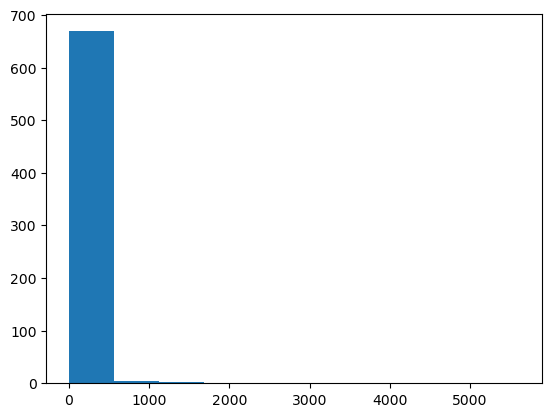

In [12]:
fits_filename = "RACS-mid1_sources.fits"
fits_filepath = Source_dir+"Catalogues\\"

test_crossmatch = get_all_SAMI_crossmatched_fits_table(fits_filepath, fits_filename, sep_arcsec=20, save_file=False)
test_crossmatch

plt.hist(test_crossmatch['Total_flux'])

In [ ]:
a = test_crossmatch[test_crossmatch['CATID']==9403801368]
print(np.sum(a['Total_flux']))

test_crossmatch[test_crossmatch['CATID']==9403801368]

94.02077048564108


CATID,RA_OBJ,DEC_OBJ,r_petro,r_auto,z_spec,M_r,r_e,mu_within_1re,mu_1re,mu_2re,ellip,PA_1,g_i,Mstar,R_on_rtwo,V_on_sigma,is_mem,SURV_SAMI,BAD_CLASS,Name,Source_ID,Field_ID,RA,Dec,Dec_corr,E_RA,E_Dec,E_Dec_corr,Total_flux,E_Total_flux_PyBDSF,E_Total_flux,Peak_flux,E_Peak_flux_PyBDSF,E_Peak_flux,Maj_axis,Min_axis,PA_2,E_Maj_axis,E_Min_axis,E_PA,DC_Maj_axis,DC_Min_axis,DC_PA,E_DC_Maj_axis,E_DC_Min_axis,E_DC_PA,Noise,Tile_l,Tile_m,Tile_sep,Gal_lon,Gal_lat,PSF_Maj,PSF_Min,PSF_PA,S_Code,N_Gaussians,Flag,Scan_start_MJD,Scan_length,SBID,E_Flux_scale,separation,SAMI_region,FILLFLAG,PA,RA_IFU,DEC_IFU,z_tonry,A_g
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,str26,str17,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,int64,int64,float64,float64,int64,float64,float64,str7,int16,float64,float64,float64,float32,float32
9403801368,357.9030151,-28.3649693,12.62164,12.59056,0.027466208,-22.976963,16.196554,20.360712,21.806812,23.375288,0.06342096,53.364494,1.3069286,11.465432,1.2769156,-0.91945124,1,2,0,RACS-MID1 J235136.6-282154,RACS_2348-28_1710,RACS_2348-28,357.90234899096237,-28.364950978312137,-28.365050505690203,7.339006879748627e-06,1.431302392922859e-05,0.00014512591418137263,94.02077048564108,1.8625087703595764,5.940757353859464,50.98023405927225,0.2302966604474932,3.0674712557529733,22.309063022499398,12.670360053184208,72.4700568503202,0.1259439008673649,0.052263180995365775,0.493419276294676,19.673455565551173,7.397051093156059,68.76901163042683,0.1259439008673649,0.052263180995365775,0.493419276294676,0.2302966604474932,0.7940113811167082,-0.3983961413048533,0.8883544105529652,24.127314914171098,-76.71369151599194,11.400000000000002,9.299999999999999,112.85,M,4,1,59210.42334123114,895.795199898987,20418,0.06,2.111118450790771,Cluster,--,--,--,--,--,--


: 

## LARGESS

In [ ]:
# converting LARGESS data from .dat to .fits 
 # initially converted the .dat and saved as a .txt file
# https://cdsarc.cds.unistra.fr/ftp/J/MNRAS/464/1306/ReadMe


LARGESS_data = ascii.read(Source_dir+"Catalogues\\LARGESS.txt")

LARGESS_labels = ('Name', 'SDSS', "RAdeg", "DEdeg", "rmag", "e_rmag", "imod", "e_imod", "gmod", "e_gmod", "NFIRST", "FFIRST", 
                  "NNVSS", "FNVSS", "z", "q_z", "zsource", "OIII-SN", "EWOIII", "VClass", "BClass", "HIcomp", "f_z", "DisGAMA")



for i, colname in enumerate(LARGESS_labels):
    LARGESS_data.rename_column(f"col{i+1}", colname)
LARGESS_data

LARGESS_savepath = Source_dir+"Catalogues\\LARGESS.fits"
LARGESS_data.write(LARGESS_savepath)

In [ ]:
fits_filename = "LARGESS.fits"
fits_filepath = Source_dir+"Catalogues\\"

get_all_SAMI_crossmatched_fits_table(fits_filepath, fits_filename, sep_arcsec=20, crossmatching_colnames=("RAdeg", "DEdeg"))

Crossmatched Table Saved to: C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Catalogues\Crossmatched\all_SAMI_target_matched_LARGESS.fits


CATID,RA_OBJ,DEC_OBJ,r_petro,r_auto,z_spec,M_r,r_e,mu_within_1re,mu_1re,mu_2re,ellip,PA,g_i,Mstar,R_on_rtwo,V_on_sigma,is_mem,SURV_SAMI,BAD_CLASS,Name,SDSS,RAdeg,DEdeg,rmag,e_rmag,imod,e_imod,gmod,e_gmod,NFIRST,FFIRST,NNVSS,FNVSS,z,q_z,zsource,OIII-SN,EWOIII,VClass,BClass,HIcomp,f_z,DisGAMA,separation,SAMI_region,FILLFLAG,RA_IFU,DEC_IFU,z_tonry,A_g
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,str19,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,int64,str9,str6,str7,str7,str7,int64,int64,int64,float64,str7,int16,float64,float64,float32,float32
9011900407,13.9759939940639,-0.922549822671979,15.190357,15.821978,0.044271052,-20.678175,1.461469,19.053984,20.116014,21.759474,0.2577744,216.80675,1.1870157,10.368644,0.5309081,0.025593681,1,7,8,J005554.54-005514.3,587731185136304141,13.97726,-0.92065,14.136,0.023,13.544,0.002,14.906,0.003,1,1.91,0,-99.0,0.04498,5,SDSS,4.36,0.49,NA,LERG,1,-1,-1,8.218479551768255,Cluster,--,--,--,--,--
9011900413,13.9772544060016,-0.920661600578013,14.059271,13.926961,0.044977106,-22.574577,16.405638,20.993736,22.508366,24.068882,0.41688353,189.22781,1.2913036,11.259835,0.5332045,0.26691934,1,7,0,J005554.54-005514.3,587731185136304141,13.97726,-0.92065,14.136,0.023,13.544,0.002,14.906,0.003,1,1.91,0,-99.0,0.04498,5,SDSS,4.36,0.49,NA,LERG,1,-1,-1,0.0463629336375491,Cluster,--,--,--,--,--
9011900538,14.2582328142653,-0.879719378143715,15.2405405,15.332901,0.046388593,-21.169817,8.971725,21.262474,23.064053,24.601055,0.4537249,26.758894,1.2032566,10.621757,0.6484036,0.74886864,1,7,0,J005702.04-005230.7,587731185136435215,14.25854,-0.87519,13.56,0.01,12.994,0.002,14.277,0.002,3,72.48,3,107.7,0.04416,5,SDSS,6.72,0.68,NA,LERG,1,-1,-1,16.343209929496542,Cluster,--,--,--,--,--
9011900547,14.2585403462785,-0.875188276838173,13.443541,13.38941,0.044160094,-23.111313,16.273212,20.81023,22.277824,23.84368,0.18596274,215.75726,1.2845736,11.466611,0.65483767,-0.012345948,1,7,0,J005702.04-005230.7,587731185136435215,14.25854,-0.87519,13.56,0.01,12.994,0.002,14.277,0.002,3,72.48,3,107.7,0.04416,5,SDSS,6.72,0.68,NA,LERG,1,-1,-1,0.006327369980158375,Cluster,--,--,--,--,--
9011900554,14.2626983164118,-0.873570283032657,16.609373,15.932645,0.04642277,-20.570168,1.7138611,19.324015,20.586428,22.182932,0.27969638,50.43177,1.2634821,10.420086,0.6599529,0.7605298,1,7,8,J005702.04-005230.7,587731185136435215,14.25854,-0.87519,13.56,0.01,12.994,0.002,14.277,0.002,3,72.48,3,107.7,0.04416,5,SDSS,6.72,0.68,NA,LERG,1,-1,-1,16.063848529634658,Cluster,--,--,--,--,--
9011901004,13.4276619272992,-1.0851857429077,14.653986,14.637396,0.046600495,-21.864511,10.401846,21.207989,22.70003,24.263044,0.35097003,111.04862,1.1292171,10.842395,1.0179218,0.82116586,1,2,0,J005342.63-010506.5,588015507664601175,13.42765,-1.08516,14.799,0.043,14.41,0.003,15.65,0.004,1,3.48,1,2.7,0.04655,4,SDSS,188.00,22.20,NA,HERG,1,-1,-1,0.10213516202824713,Cluster,--,--,--,--,--
9011901426,14.3650945311976,-0.471593857820377,14.26764,14.09101,0.043910038,-22.408506,11.067292,20.605507,22.321672,23.86432,0.34577075,262.52768,1.3811578,11.27145,1.2900373,-0.09786215,1,2,0,J005727.62-002817.6,587731185673306247,14.36509,-0.47158,14.266,0.02,13.717,0.002,15.076,0.003,1,4.99,1,5.8,0.04391,5,SDSS,3.41,0.46,NA,LERG,1,-1,-1,0.052487153871046036,Cluster,--,--,--,--,--
9016800001,18.739974118087,0.430806769669402,13.466736,13.493587,0.044836815,-23.043924,23.538727,21.758163,23.253756,24.81637,0.12198695,155.11876,1.2796707,11.44393,0.552757,-0.041373115,1,7,0,J011457.59+002550.9,588015509814444216,18.73996,0.43081,13.649,0.005,13.084,0.002,14.364,0.002,1,3.13,1,4.1,0.04479,5,SDSS,3.13,0.47,NA,LERG,1,-1,-1,0.0521371667472698,Cluster,--,--,--,--,--


## eROSITA

In [ ]:
fits_filename = "eRASS1_Main.v1.1.fits"
fits_filepath = Source_dir+"Catalogues\\"

with fits.open(fits_filepath + fits_filename) as eROSITA_hdul:
    eROSITA_hdul.info



get_all_SAMI_crossmatched_fits_table(fits_filepath, fits_filename, sep_arcsec=40, crossmatching_colnames=("RA", "DEC"))

Crossmatched Table Saved to: C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Catalogues\Crossmatched\all_SAMI_target_matched_eRASS1_Main.v1.1.fits


CATID,RA_OBJ,DEC_OBJ,r_petro,r_auto,z_spec,M_r,r_e,mu_within_1re,mu_1re,mu_2re,ellip,PA,g_i,Mstar,R_on_rtwo,V_on_sigma,is_mem,SURV_SAMI,BAD_CLASS,IAUNAME,DETUID,SKYTILE,ID_SRC,UID,UID_Hard,ID_CLUSTER,RA,DEC,RA_RAW,DEC_RAW,RA_LOWERR,RA_UPERR,DEC_LOWERR,DEC_UPERR,POS_ERR,RADEC_ERR,LII,BII,ELON,ELAT,MJD,MJD_MIN,MJD_MAX,EXT,EXT_ERR,EXT_LOWERR,EXT_UPERR,EXT_LIKE,DET_LIKE_0,ML_CTS_1,ML_CTS_ERR_1,ML_CTS_LOWERR_1,ML_CTS_UPERR_1,ML_RATE_1,ML_RATE_ERR_1,ML_RATE_LOWERR_1,ML_RATE_UPERR_1,ML_FLUX_1,ML_FLUX_ERR_1,ML_FLUX_LOWERR_1,ML_FLUX_UPERR_1,ML_BKG_1,ML_EXP_1,ML_EEF_1,APE_CTS_1,APE_BKG_1,APE_EXP_1,APE_RADIUS_1,APE_POIS_1,DET_LIKE_P1,ML_CTS_P1,ML_CTS_ERR_P1,ML_CTS_LOWERR_P1,ML_CTS_UPERR_P1,ML_RATE_P1,ML_RATE_ERR_P1,ML_RATE_LOWERR_P1,ML_RATE_UPERR_P1,ML_FLUX_P1,ML_FLUX_ERR_P1,ML_FLUX_LOWERR_P1,ML_FLUX_UPERR_P1,ML_BKG_P1,ML_EXP_P1,ML_EEF_P1,APE_CTS_P1,APE_BKG_P1,APE_EXP_P1,APE_RADIUS_P1,APE_POIS_P1,DET_LIKE_P2,ML_CTS_P2,ML_CTS_ERR_P2,ML_CTS_LOWERR_P2,ML_CTS_UPERR_P2,ML_RATE_P2,ML_RATE_ERR_P2,ML_RATE_LOWERR_P2,ML_RATE_UPERR_P2,ML_FLUX_P2,ML_FLUX_ERR_P2,ML_FLUX_LOWERR_P2,ML_FLUX_UPERR_P2,ML_BKG_P2,ML_EXP_P2,ML_EEF_P2,APE_CTS_P2,APE_BKG_P2,APE_EXP_P2,APE_RADIUS_P2,APE_POIS_P2,DET_LIKE_P3,ML_CTS_P3,ML_CTS_ERR_P3,ML_CTS_LOWERR_P3,ML_CTS_UPERR_P3,ML_RATE_P3,ML_RATE_ERR_P3,ML_RATE_LOWERR_P3,ML_RATE_UPERR_P3,ML_FLUX_P3,ML_FLUX_ERR_P3,ML_FLUX_LOWERR_P3,ML_FLUX_UPERR_P3,ML_BKG_P3,ML_EXP_P3,ML_EEF_P3,APE_CTS_P3,APE_BKG_P3,APE_EXP_P3,APE_RADIUS_P3,APE_POIS_P3,DET_LIKE_P4,ML_CTS_P4,ML_CTS_ERR_P4,ML_CTS_LOWERR_P4,ML_CTS_UPERR_P4,ML_RATE_P4,ML_RATE_ERR_P4,ML_RATE_LOWERR_P4,ML_RATE_UPERR_P4,ML_FLUX_P4,ML_FLUX_ERR_P4,ML_FLUX_LOWERR_P4,ML_FLUX_UPERR_P4,ML_BKG_P4,ML_EXP_P4,ML_EEF_P4,APE_CTS_P4,APE_BKG_P4,APE_EXP_P4,APE_RADIUS_P4,APE_POIS_P4,DET_LIKE_P5,ML_CTS_P5,ML_CTS_ERR_P5,ML_CTS_LOWERR_P5,ML_CTS_UPERR_P5,ML_RATE_P5,ML_RATE_ERR_P5,ML_RATE_LOWERR_P5,ML_RATE_UPERR_P5,ML_FLUX_P5,ML_FLUX_ERR_P5,ML_FLUX_LOWERR_P5,ML_FLUX_UPERR_P5,ML_BKG_P5,ML_EXP_P5,ML_EEF_P5,APE_CTS_P5,APE_BKG_P5,APE_EXP_P5,APE_RADIUS_P5,APE_POIS_P5,DET_LIKE_P6,ML_CTS_P6,ML_CTS_ERR_P6,ML_CTS_LOWERR_P6,ML_CTS_UPERR_P6,ML_RATE_P6,ML_RATE_ERR_P6,ML_RATE_LOWERR_P6,ML_RATE_UPERR_P6,ML_FLUX_P6,ML_FLUX_ERR_P6,ML_FLUX_LOWERR_P6,ML_FLUX_UPERR_P6,ML_BKG_P6,ML_EXP_P6,ML_EEF_P6,APE_CTS_P6,APE_BKG_P6,APE_EXP_P6,APE_RADIUS_P6,APE_POIS_P6,DET_LIKE_P7,ML_CTS_P7,ML_CTS_ERR_P7,ML_CTS_LOWERR_P7,ML_CTS_UPERR_P7,ML_RATE_P7,ML_RATE_ERR_P7,ML_RATE_LOWERR_P7,ML_RATE_UPERR_P7,ML_FLUX_P7,ML_FLUX_ERR_P7,ML_FLUX_LOWERR_P7,ML_FLUX_UPERR_P7,ML_BKG_P7,ML_EXP_P7,ML_EEF_P7,APE_CTS_P7,APE_BKG_P7,APE_EXP_P7,APE_RADIUS_P7,APE_POIS_P7,DET_LIKE_P8,ML_CTS_P8,ML_CTS_ERR_P8,ML_CTS_LOWERR_P8,ML_CTS_UPERR_P8,ML_RATE_P8,ML_RATE_ERR_P8,ML_RATE_LOWERR_P8,ML_RATE_UPERR_P8,ML_FLUX_P8,ML_FLUX_ERR_P8,ML_FLUX_LOWERR_P8,ML_FLUX_UPERR_P8,ML_BKG_P8,ML_EXP_P8,ML_EEF_P8,APE_CTS_P8,APE_BKG_P8,APE_EXP_P8,APE_RADIUS_P8,APE_POIS_P8,DET_LIKE_P9,ML_CTS_P9,ML_CTS_ERR_P9,ML_CTS_LOWERR_P9,ML_CTS_UPERR_P9,ML_RATE_P9,ML_RATE_ERR_P9,ML_RATE_LOWERR_P9,ML_RATE_UPERR_P9,ML_FLUX_P9,ML_FLUX_ERR_P9,ML_FLUX_LOWERR_P9,ML_FLUX_UPERR_P9,ML_BKG_P9,ML_EXP_P9,ML_EEF_P9,APE_CTS_P9,APE_BKG_P9,APE_EXP_P9,APE_RADIUS_P9,APE_POIS_P9,APE_CTS_S,APE_BKG_S,APE_EXP_S,APE_POIS_S,FLAG_SP_SNR,FLAG_SP_BPS,FLAG_SP_SCL,FLAG_SP_LGA,FLAG_SP_GC_CONS,FLAG_NO_RADEC_ERR,FLAG_NO_EXT_ERR,FLAG_NO_CTS_ERR,FLAG_OPT,separation,SAMI_region,FILLFLAG,RA_IFU,DEC_IFU,z_tonry,A_g
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,str23,str32,int32,int32,int64,int64,int32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32

| CUBEID | CUBEIDPUB| CATID | Z_SPEC| RA_OBJ | DEC_OBJ | SAMI_REGION | IN_(MATCHING_CAT) | MATCHED_IDs_(MATCHING_CAT) | ...

first three from CubeObs.fits
Z_Spec from EmissionLine1compDR3.fits 
RA_OBJ, DEC_OBJ from target catalogue (need to iterate through all 3)
then for each crossmatching catalogue do IN_(MATCHING_CAT) which will be a boolean, then (MATCHING_CAT)_IDs which will be a tuple of the IDS matched to in the crossmatched survey

to implement sort everything but CATID


## Summary Table

In [ ]:
SAMI_Cubes_catalogue = "CubeObs.fits"
SAMI_spectra_catalogue = "EmissionLine1compDR3.fits"
fits_filepath = Source_dir+"Catalogues\\"
SAMI_regions = ("Cluster", "Filler", "GAMA")


with fits.open(fits_filepath+SAMI_Cubes_catalogue) as SAMI_Cubes_hdul:

    #initialise table with first 3 columns
    Summary_table_hdu =  Table(SAMI_Cubes_hdul[1].data)

    Summary_table_hdu.keep_columns(('CUBEID', 'CUBEIDPUB', 'CATID'))
    Summary_table_hdu.sort('CATID')

    # get list of CATIDs for iteration further on
print(len(Summary_table_hdu))


# fourth column Z_Spec from emissionline catalogue
with fits.open(fits_filepath + SAMI_spectra_catalogue) as SAMI_spectra_hdul:
    SAMI_spectra_table_hdu = Table(SAMI_spectra_hdul[1].data)
    SAMI_spectra_table_hdu.keep_columns(('CATID', 'Z_SPEC'))
    SAMI_spectra_table_hdu.sort('CATID')

Summary_table_hdu = join(Summary_table_hdu, SAMI_spectra_table_hdu, keys='CATID', join_type='left')
print(len(Summary_table_hdu))

# RA_OBJ and DEC_OBJ from the three filler catalogues and SAMI_REGION
Target_region_table_ls = []
for k, SAMI_Target_catalogue in enumerate(SAMI_Target_catalogues):
    with fits.open(fits_filepath + SAMI_Target_catalogue) as SAMI_Target_hdul:
        SAMI_Target_table_hdu = Table(SAMI_Target_hdul[1].data)
        SAMI_Target_table_hdu.keep_columns(('CATID', 'RA_OBJ', 'DEC_OBJ'))
        SAMI_Target_table_hdu.add_column(astropy.table.Column([SAMI_regions[k]]*len(SAMI_Target_table_hdu), name='SAMI_region'))

    Target_region_table_ls.append(SAMI_Target_table_hdu)
    
all_SAMI_Targets_table = astropy.table.vstack(Target_region_table_ls)
Summary_table_hdu = join(Summary_table_hdu, all_SAMI_Targets_table, keys='CATID', join_type='left')
print(len(Summary_table_hdu))


# adding other catalogue info

crossmatching_catalogues = ("RACS-mid1_components.fits", "RACS-mid1_sources.fits", "LARGESS.fits", "eRASS1_Main.v1.1.fits")
crossmatching_ID_columns = ("Source_ID", "Source_ID", 'Name', 'IAUNAME')

for k, crossmatching_catalogue in enumerate(crossmatching_catalogues):
    crossmatched_filename = f"all_SAMI_target_matched_{crossmatching_catalogue}"
    crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename

    with fits.open(crossmatched_filepath) as crossmatched_hdul:
        crossmatched_table_hdu = Table(crossmatched_hdul[1].data)

        is_in_crossmatch = []
        all_matching_ids = []
        for CAT_ID in Summary_table_hdu['CATID'].data:
            matched_rows = crossmatched_table_hdu[crossmatched_table_hdu['CATID'] == CAT_ID]
            matching_ids = matched_rows[crossmatching_ID_columns[k]].data

            if len(matching_ids) >0:
                is_in_crossmatch.append(True)
                all_matching_ids.append(1)                             #f'{matching_ids[0]}') #need to fix this so it appens the minimum one

            elif len(matching_ids) ==0:
                is_in_crossmatch.append(False)
                all_matching_ids.append( 0 )

        Summary_table_hdu.add_column(astropy.table.Column(is_in_crossmatch, name=f'IN_{crossmatching_catalogue[:-5]}'))
        Summary_table_hdu.add_column(astropy.table.Column(all_matching_ids, name=f'MATCHED_IDs_{crossmatching_catalogue[:-5]}'))


crossmatched_filename = f"all_SAMI_target_matched_All_Surveys.fits"

crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename
Summary_table_hdu.write(crossmatched_filepath)
print(f"Crossmatched Table Saved to: {crossmatched_filepath}")



Summary_table_hdu

3712
4684
4684
Crossmatched Table Saved to: C:\Users\mspan\OneDrive - The University of Sydney (Students)\Honours\Catalogues\Crossmatched\all_SAMI_target_matched_All_Surveys.fits


CUBEIDPUB,CUBEID,CATID,Z_SPEC,RA_OBJ,DEC_OBJ,SAMI_region,IN_RACS-mid1_components,MATCHED_IDs_RACS-mid1_components,IN_RACS-mid1_sources,MATCHED_IDs_RACS-mid1_sources,IN_LARGESS,MATCHED_IDs_LARGESS,IN_eRASS1_Main.v1.1,MATCHED_IDs_eRASS1_Main.v1.1
str16,str80,int64,float32,float64,float64,str7,bool,int32,bool,int32,bool,int32,bool,int32
6821_A,6821_7_Y18SAR4_P001_12T126_2018_05_07-2018_05_16,6821,0.00375,174.15315328,0.8154385533333334,GAMA,False,0,False,0,False,0,False,0
6837_A,6837_7_Y18SAR4_P001_12T126_2018_05_07-2018_05_16,6837,0.07424,174.302786008,0.789984596388,Filler,False,0,False,0,False,0,False,0
7139_A,7139_7_Y18SAR3_P002_12T122_2018_05_07-2018_05_16,7139,0.07567,175.82830466,0.74788117,GAMA,False,0,False,0,False,0,False,0
7206_A,7206_7_Y18SAR3_P002_12T122_2018_05_07-2018_05_16,7206,0.09339,176.16409281,0.7495694,GAMA,False,0,False,0,False,0,False,0
7289_A,7289_7_Y18SAR3_P002_12T122_2018_05_07-2018_05_16,7289,0.08682,176.77502491,0.63568906,GAMA,False,0,False,0,False,0,False,0
7715_A,7715_7_Y14SAR4_P002_12T064_2014_05_23-2014_06_01,7715,0.07798,179.22873399,0.72391972,GAMA,False,0,False,0,False,0,False,0
7839_A,7839_7_Y16SAR4_P002_12T101_2017_04_19-2017_05_01,7839,0.04749,179.61542288,0.71790602,GAMA,False,0,False,0,True,1,False,0
7841_A,7841_7_Y14SAR4_P002_12T064_2014_05_23-2014_06_01,7841,0.07852,179.60882677,0.713106,GAMA,False,0,False,0,False,0,False,0
7946_A,7946_7_Y16SAR4_P002_12T101_2017_04_19-2017_05_01,7946,0.10295,179.93476301,0.63536903,GAMA,False,0,False,0,False,0,False,0


In [ ]:
from astropy.table import Table
t = Table({"a": [2., 3., 5.], "b": [7., 11., 13.]})
t[0].get("a")
np.float64(2.0)
t[1].get("b", 0.)
np.float64(11.0)
t[2].get("c", 0.)
0.0

t

a,b
float64,float64
2.0,7.0
3.0,11.0
5.0,13.0


In [ ]:
sum(Summary_table_hdu['IN_RACS-mid1_components'].data)

414

: 

# PLOTS:

C:\Users\mspan\AppData\Local\Temp\ipykernel_34328\1657733011.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


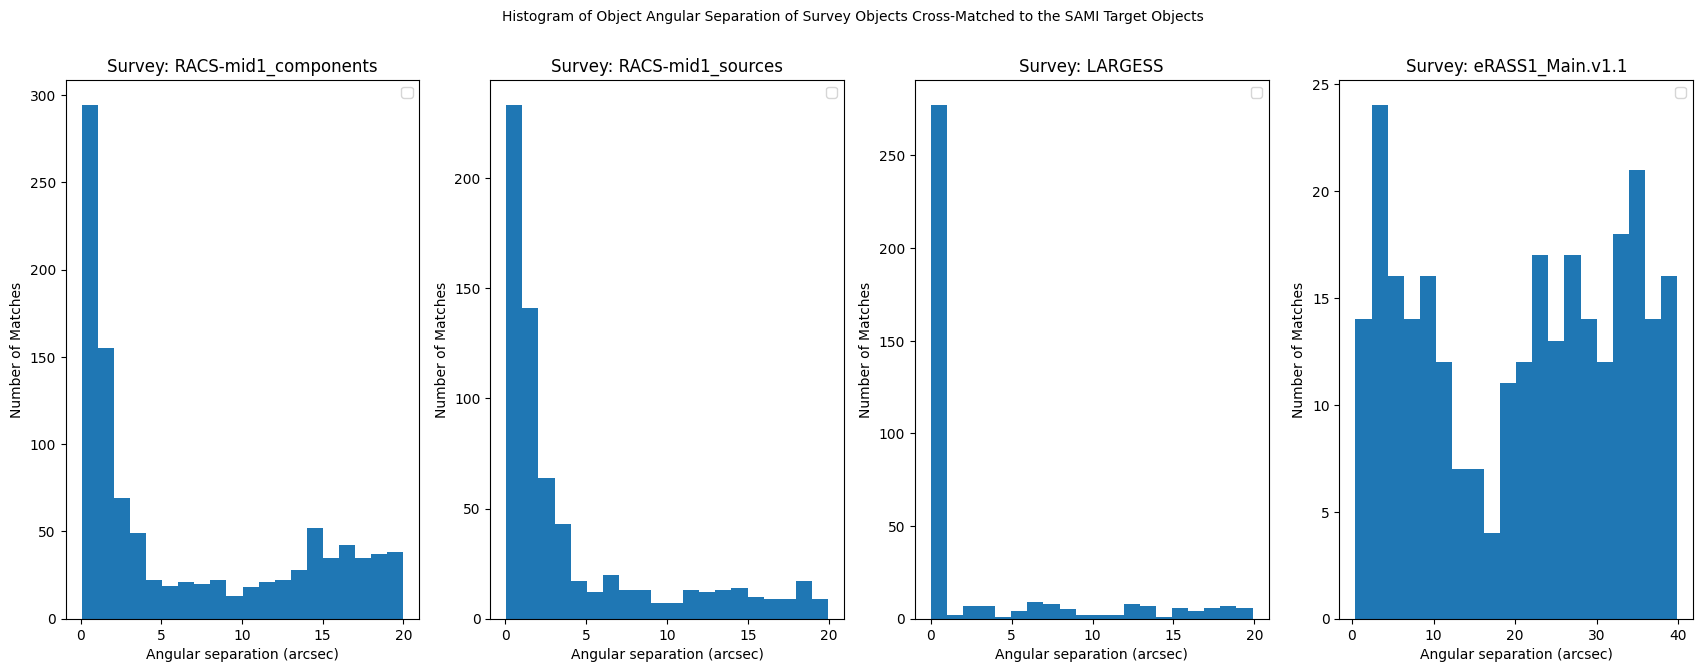

In [25]:
""" Looking at speration of cross-matches to determine where appropriate cutoff should be
"""

crossmatching_catalogues = ("RACS-mid1_components.fits", "RACS-mid1_sources.fits", "LARGESS.fits", "eRASS1_Main.v1.1.fits")
crossmatching_catalogue = crossmatching_catalogues[0]
fits_filepath = Source_dir+"Catalogues\\"


height, width = 7, 21
fig1, axs1 = plt.subplots(1, 4)
fig1.set_figheight(height)
fig1.set_figwidth(width)
fig1.suptitle(f'Histogram of Object Angular Separation of Survey Objects Cross-Matched to the SAMI Target Objects', fontsize=10)


for i, crossmatching_catalogue in enumerate(crossmatching_catalogues):
    crossmatched_filename = f"all_SAMI_target_matched_{crossmatching_catalogue}"
    crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename

    with fits.open(crossmatched_filepath) as crossmatched_hdul:
        crossmatched_table_hdu = Table(crossmatched_hdul[1].data)

        separation_array = np.array(crossmatched_table_hdu['separation'])
        region_ls = crossmatched_table_hdu['SAMI_region']

    
    ax = axs1.flatten()[i]
    nbins = 20
    ax.hist(separation_array, bins = nbins)
    ax.set_title(f"Survey: {crossmatching_catalogue[:-5]}")
    ax.legend()
    ax.set_xlabel('Angular separation (arcsec)')
    ax.set_ylabel('Number of Matches')


#crossmatched_table_hdu


C:\Users\mspan\AppData\Local\Temp\ipykernel_38920\3266083820.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


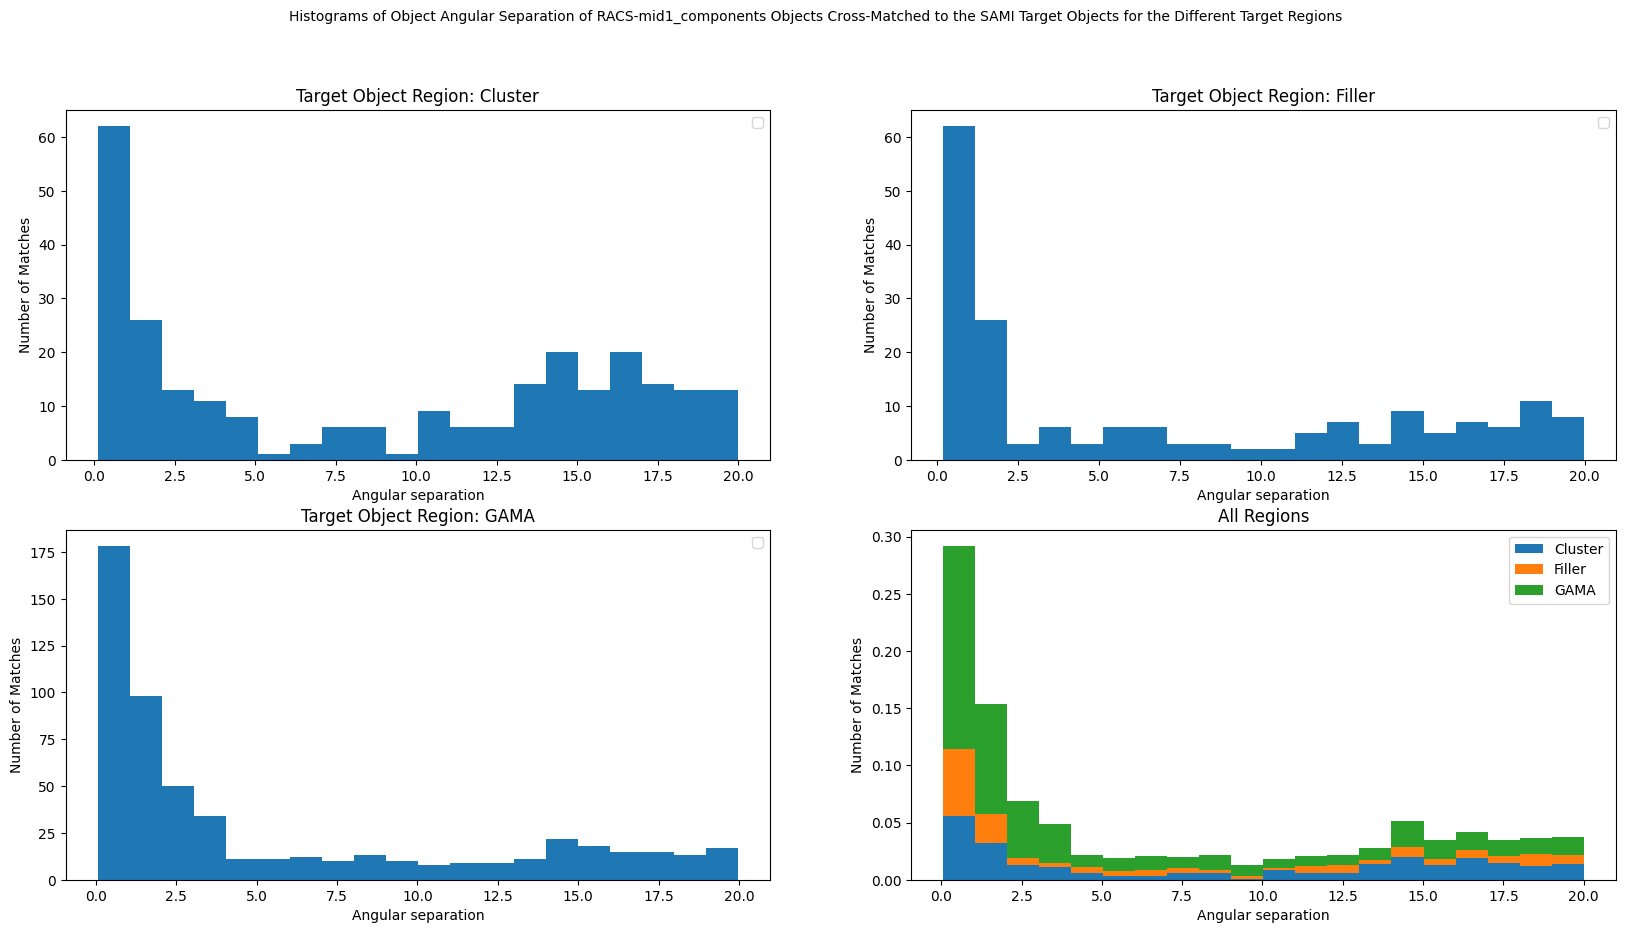

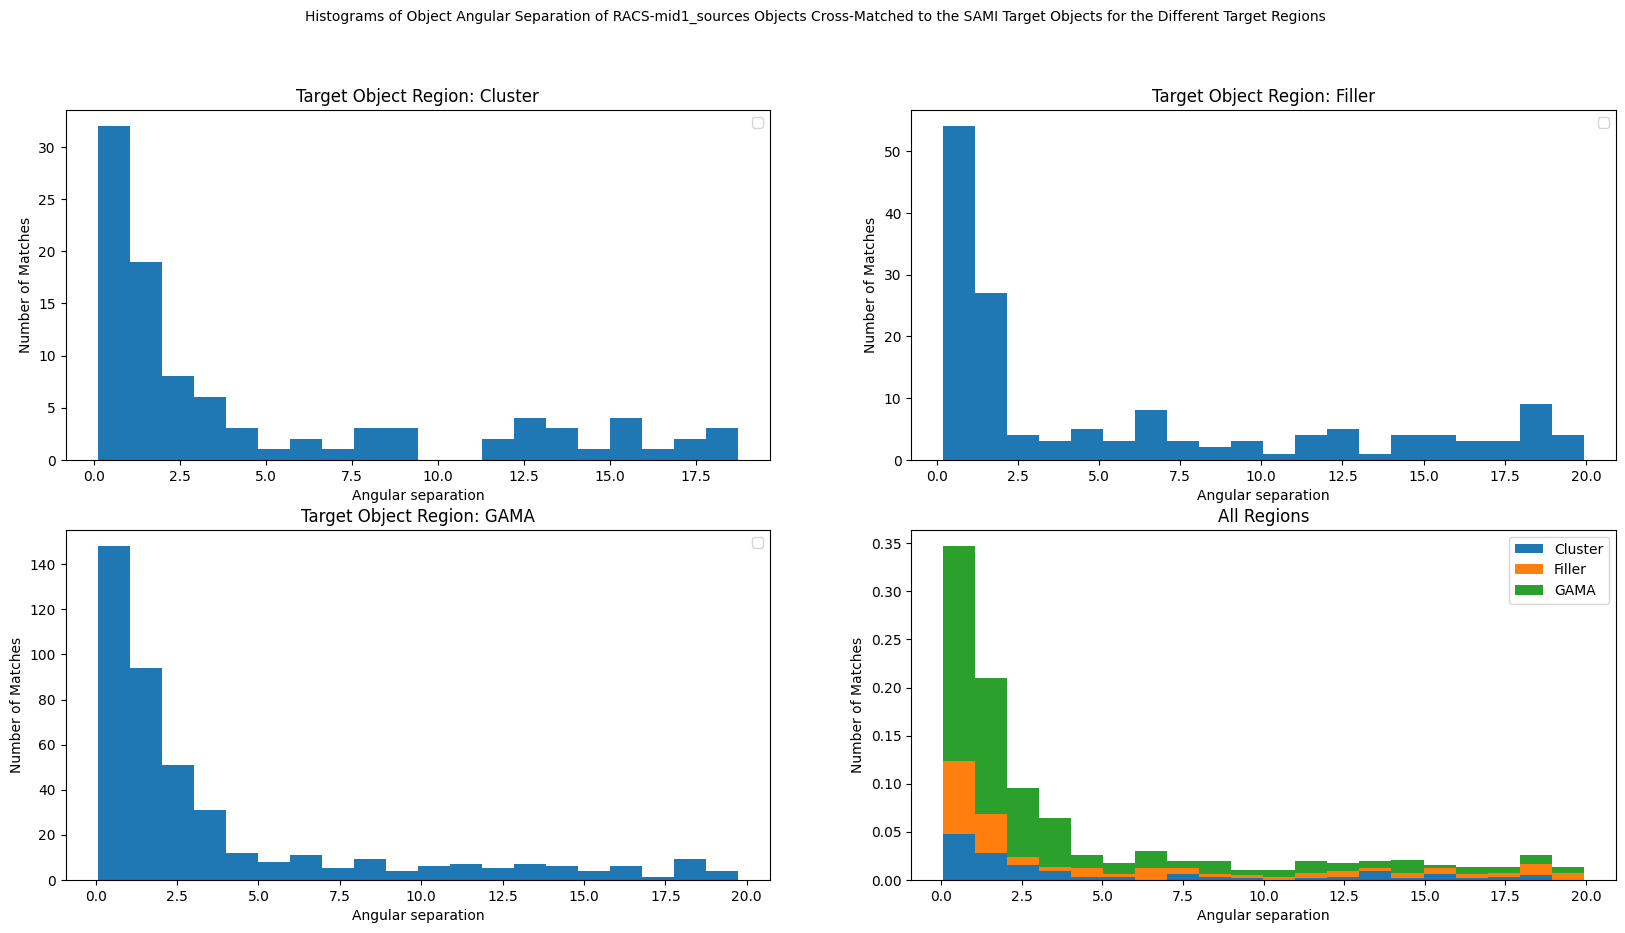

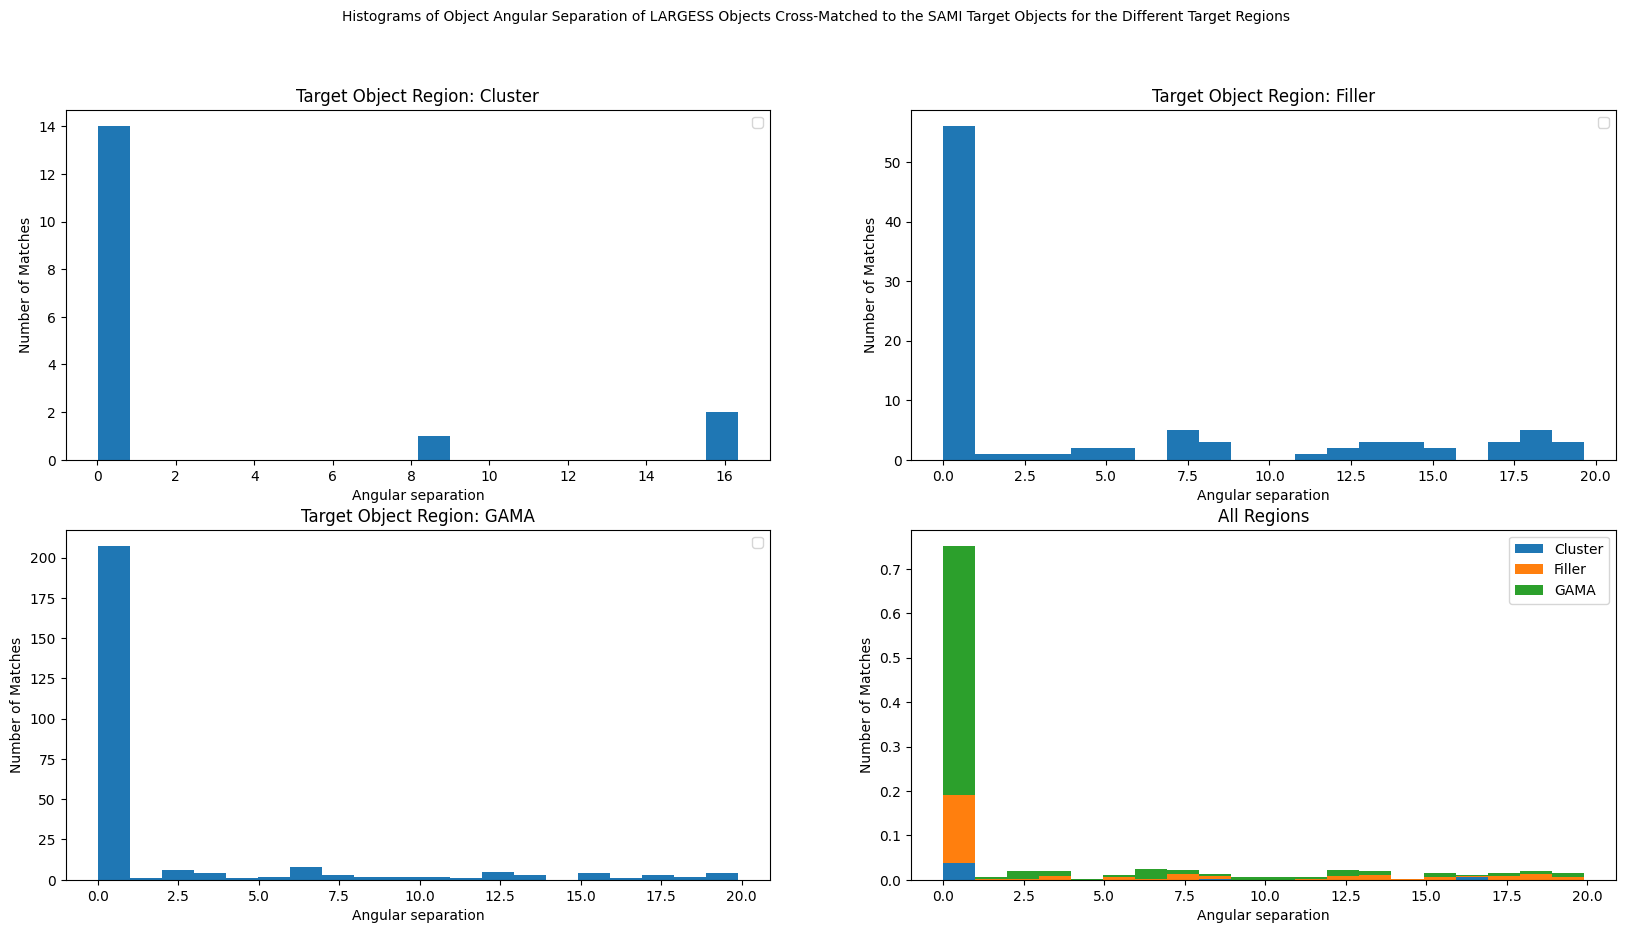

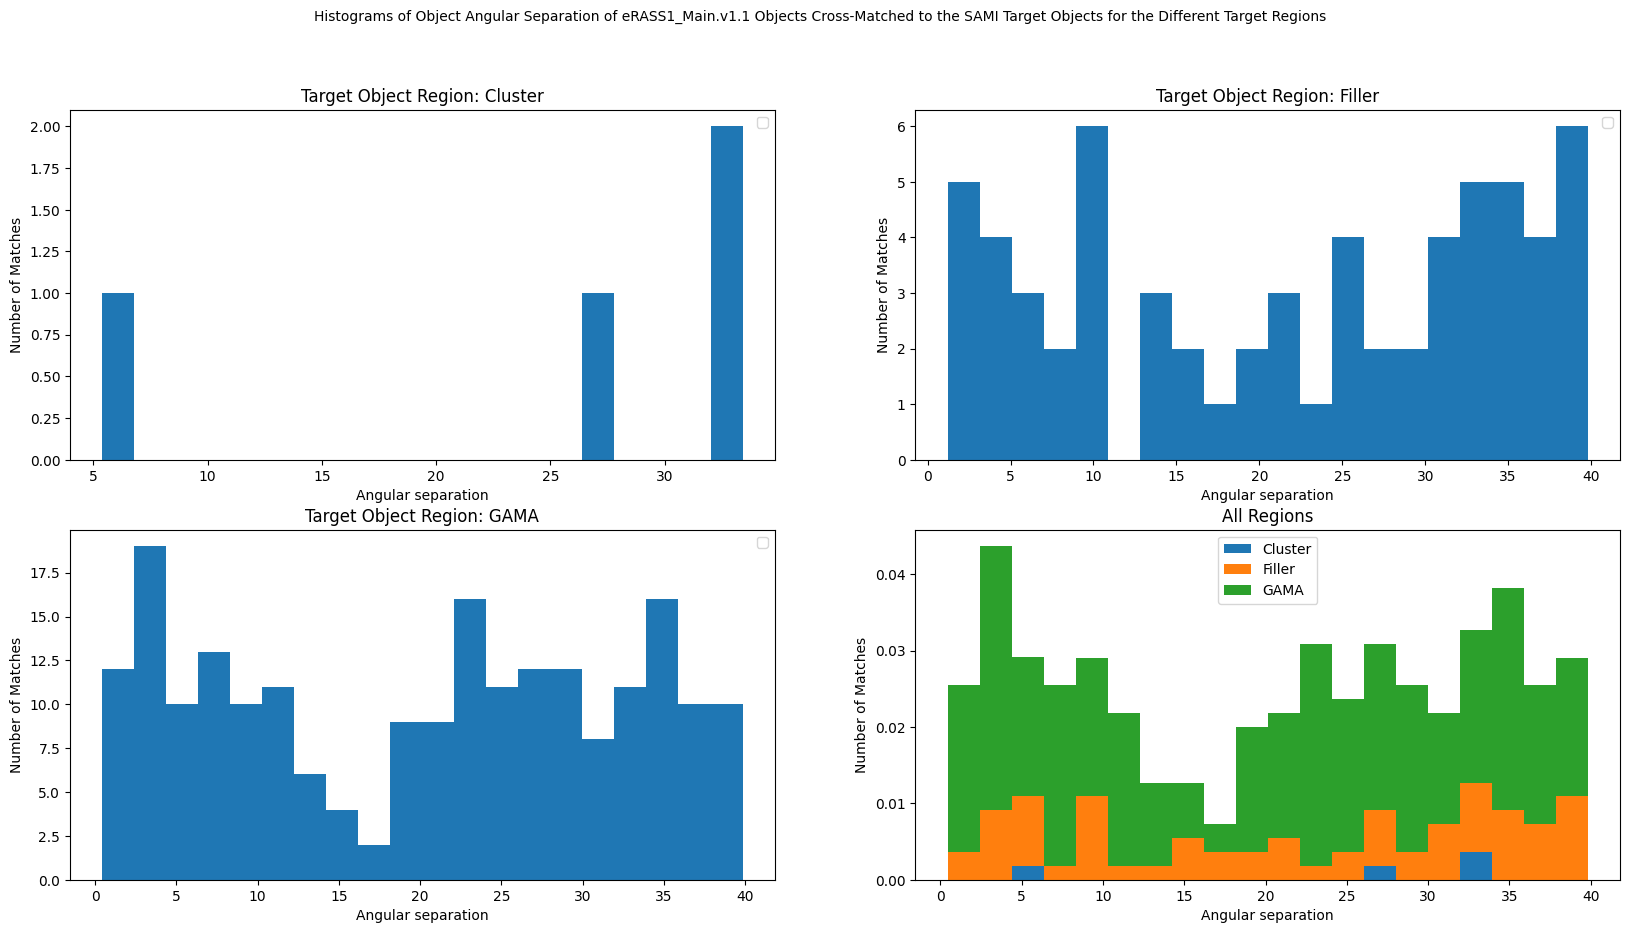

In [ ]:
""" Looking at region by region
"""






for i, crossmatching_catalogue in enumerate(crossmatching_catalogues):    
    height, width = 10, 20
    fig1, axs1 = plt.subplots(2, 2)
    fig1.set_figheight(height)
    fig1.set_figwidth(width)
    fig1.suptitle(f'Histograms of Object Angular Separation of {crossmatching_catalogue[:-5]} Objects Cross-Matched to the SAMI Target Objects for the Different Target Regions', fontsize=10)

    crossmatched_filename = f"all_SAMI_target_matched_{crossmatching_catalogue}"
    crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename

    with fits.open(crossmatched_filepath) as crossmatched_hdul:
        crossmatched_table_hdu = Table(crossmatched_hdul[1].data)

        separation_array = np.array(crossmatched_table_hdu['separation'])
        region_ls = crossmatched_table_hdu['SAMI_region']
        sep_regions = [0,0,0]

    for j, region in enumerate(SAMI_regions):    
        region_separation_array = separation_array[region_ls==region]

        sep_regions[j] = region_separation_array

        ax = axs1.flatten()[j]
        nbins = 20
        ax.hist(region_separation_array, bins = nbins)
        ax.set_title(f"Target Object Region: {region}")
        ax.legend()
        ax.set_xlabel('Angular separation')
        ax.set_ylabel('Number of Matches')

    ax = axs1.flatten()[3]
    nbins = 20
    ax.hist(sep_regions, bins = nbins, stacked=True, density=True, label=SAMI_regions)
    ax.set_title(f"All Regions")
    ax.legend()
    ax.set_xlabel('Angular separation')
    ax.set_ylabel('Number of Matches')

    


#crossmatched_table_hdu


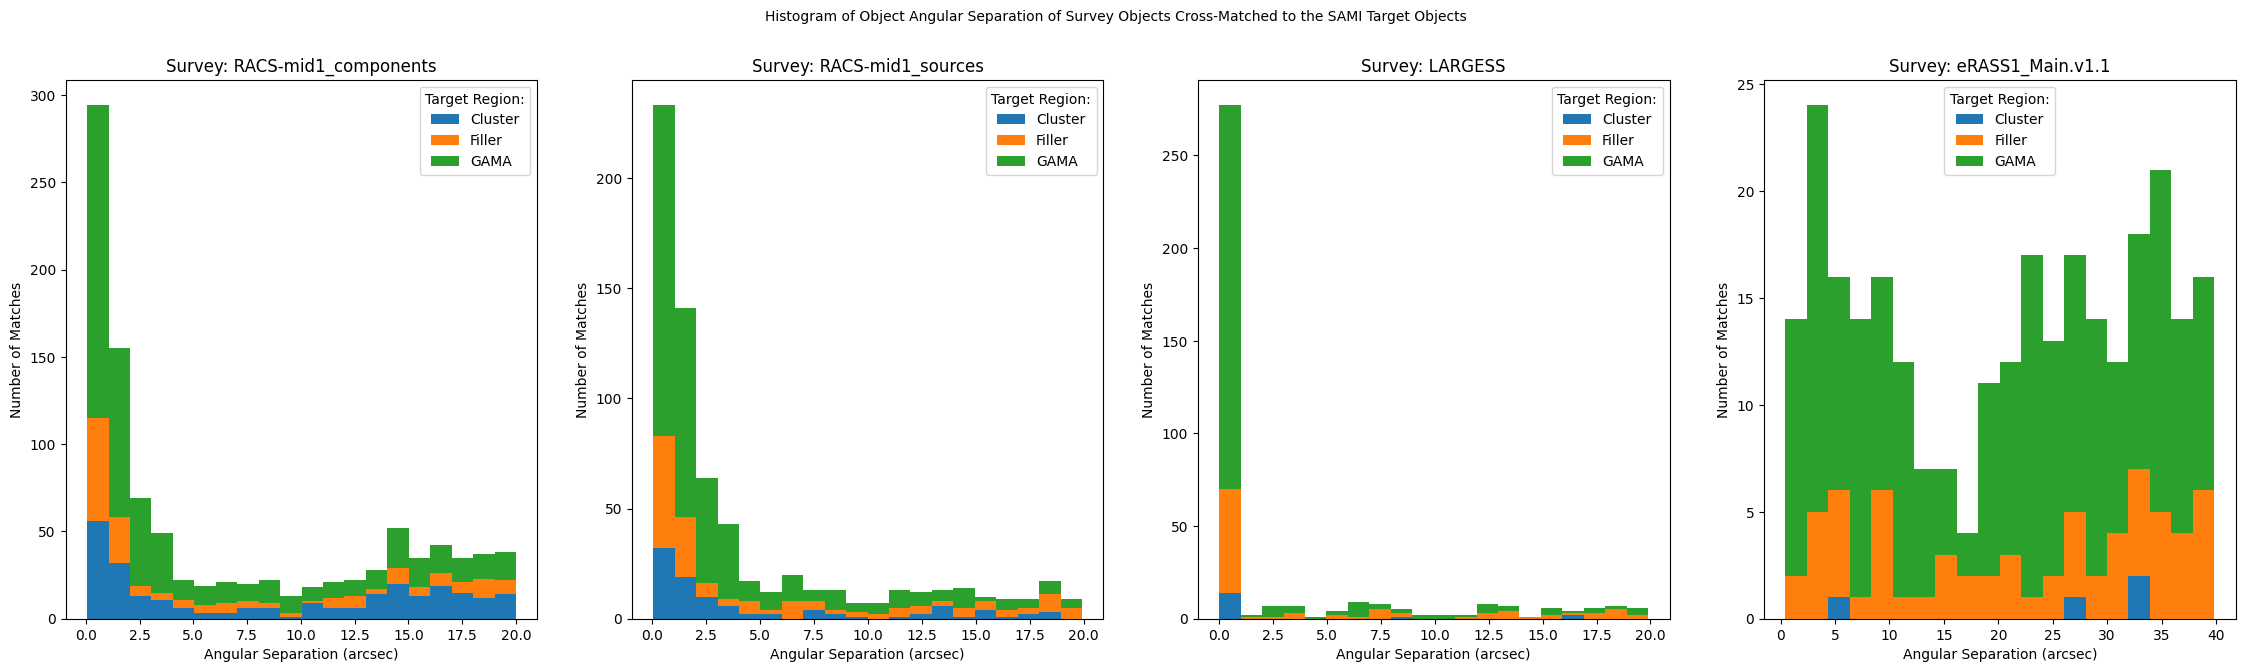

In [20]:
height, width = 7, 28
fig1, axs1 = plt.subplots(1, 4)
fig1.set_figheight(height)
fig1.set_figwidth(width)
fig1.suptitle(f'Histogram of Object Angular Separation of Survey Objects Cross-Matched to the SAMI Target Objects', fontsize=10)


for i, crossmatching_catalogue in enumerate(crossmatching_catalogues):    

    crossmatched_filename = f"all_SAMI_target_matched_{crossmatching_catalogue}"
    crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename

    with fits.open(crossmatched_filepath) as crossmatched_hdul:
        crossmatched_table_hdu = Table(crossmatched_hdul[1].data)

        separation_array = np.array(crossmatched_table_hdu['separation'])
        region_ls = crossmatched_table_hdu['SAMI_region']
        sep_regions = [0,0,0]

    for j, region in enumerate(SAMI_regions):    
        region_separation_array = separation_array[region_ls==region]
        sep_regions[j] = region_separation_array


    ax = axs1.flatten()[i]
    nbins = 20
    ax.hist(sep_regions, bins = nbins, stacked=True, label=SAMI_regions)
    ax.set_title(f"Survey: {crossmatching_catalogue[:-5]}")
    ax.legend(title='Target Region:')
    ax.set_xlabel('Angular Separation (arcsec)')
    ax.set_ylabel('Number of Matches')


In [12]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

# Load a HEALPix map (replace with your survey data)
nside = 128  # Resolution of the HEALPix map
npix = hp.nside2npix(nside)
survey_map = np.zeros(npix)  # Example: Empty map
indices = np.random.choice(npix, 5000, replace=False)  # Random points in the survey
survey_map[indices] = 1  # Mark observed regions

# Plot in Mollweide projection
hp.mollview(survey_map, title="Survey Coverage", cmap="Blues")
plt.show()



ModuleNotFoundError: No module named 'healpy'

  Using cached healpy-1.18.1.tar.gz (4.8 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build healpy
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for healpy (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [195 lines of output]
      C:\Users\mspan\AppData\Local\Temp\pip-build-env-jol5ju2d\overlay\Lib\site-packages\setuptools\_distutils\extension.py:150: UserWarning: Unknown Extension options: 'cython_directives'
        warnings.warn(msg)
      C:\Users\mspan\AppData\Local\Temp\pip-build-env-jol5ju2d\overlay\Lib\site-packages\setuptools\config\_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove deprecated calls
              or your

# Random misalignment Plots

In [6]:
crossmatching_catalogues = ("RACS-mid1_sources.fits", "LARGESS.fits", "eRASS1_Main.v1.1.fits")
fits_filepath = Source_dir + "Catalogues\\"


When generating random points to crossmatch to, probably not beneficial to just add a random number to every point as for RACS this will be >3e6 sources. Could instead maybe generate a random layout of the same number (as in the cutout of the RACS) in each region so same density. 


for each individual SAMI region:

    #get number of points in the region cutout of the survey
    num_points = len(get_RA_Dec_cutout_fits_table)

    # then generate random distribution dependent on region shape

    if GAMA:
    unif(lat_bounds), unif(long_bounds)

    if Cluster:
    spherically uniform


In [17]:
8%3

2

In [76]:

def get_unif_rand_points_in_region(num_points, bounds, region_type = 'rect', make_table=False):
    '''
    generates a uniformly random distribution of num_points points within a circular or rectangular region with bounds
    '''

    if region_type in ('rect', 'GAMA'):
        RA_array = np.random.uniform(bounds[0][0], bounds[1][0], size=num_points) %360 # to endure RA remains within [0, 360)
        Dec_array = np.random.uniform(bounds[0][1], bounds[1][1], size=num_points)
    
    elif region_type in ('circ', 'Cluster'):
        r_bound = bounds[1]
        theta = np.random.uniform(0,2*np.pi, num_points)
        radius = np.random.uniform(0,r_bound**2, num_points) **0.5

        RA_array = (bounds[0][0]+ radius * np.cos(theta) )
        Dec_array = bounds[0][1]+ radius * np.sin(theta)
        
    else:
        raise TypeError(f"Invalid bound type: {region_type}. Valid types are \'rect\' and \'circ\'")

    if make_table:

        return Table([RA_array, Dec_array], names=('RA', 'Dec'))
    else:
        return RA_array, Dec_array


def get_randomised_pos_table(catalogue_table, rand_lims=(0.1, 0.1), col_names = ('RA', 'Dec')):
    '''
    generates a randomly shifted catalogue\\
    rand_lims = (RA_shift, Dec_shift) in degrees
    '''

    rand_RA_shift = np.random.uniform(-rand_lims[0], rand_lims[0], size=len(catalogue_table))
    rand_Dec_shift = np.random.uniform(-rand_lims[1], rand_lims[1], size=len(catalogue_table))

    shifted_RA_array = catalogue_table[col_names[0]] + rand_RA_shift
    shifted_Dec_array = catalogue_table[col_names[1]] + rand_Dec_shift

    return Table([shifted_RA_array, shifted_Dec_array], names=('RA', 'Dec'))
    
    

In [57]:
180%360

180

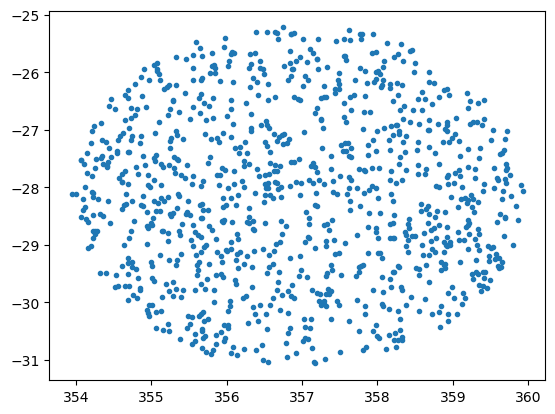

In [75]:
test = get_unif_rand_points_in_region(1000,  ((356.937810, -28.140661), 3), region_type='circ')
plt.plot(test[0], test[1], '.')

GAMA
GAMA
GAMA
Cluster
Cluster
Cluster
Cluster
Cluster
Cluster
Cluster
Cluster


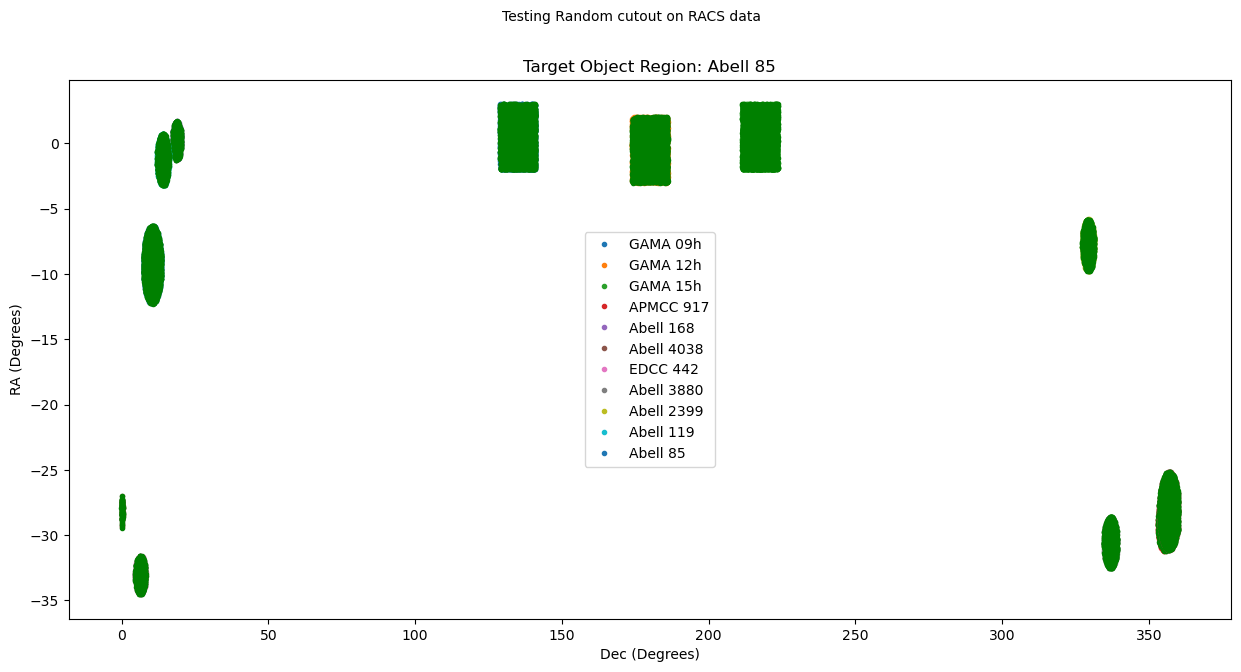

In [78]:
refresh_module()

crossmatching_colnames_dict = {'SAMI': ('RA_OBJ', 'DEC_OBJ'),
                               'RACS-mid1_sources.fits': ('RA', 'Dec'),
                               'LARGESS.fits': ("RAdeg", "DEdeg"),
                               'eRASS1_Main.v1.1.fits': ('RA', 'DEC')}

GAMA_region_bounds = [((129,-2), (141, 3)), ((174, -3), (186, 2)), ((211.5, -2), (223.5, 3))] # bounds of the GAMA target regions in the SAMI data including filler which are rectangular in shape (bottom left to top right coords) all in degrees
Cluster_region_bounds = [((355.397880, -29.236351), 2), ((18.815777, 0.213486), 1.5), ((18.739974, 0.430807), 1), 
                            ((356.937810, -28.140661), 3), ((6.380680, -33.046570), 1.5), ((336.977050, -30.575371), 2), 
                            ((329.372605, -7.795692), 2), ((14.067150, -1.255370), 2), ((10.460211, -9.303184), 3)] # bounds of the Cluster target regions (including filler targets) circular in shape  ((x_centre,y_centre), r_approx) all in degrees

SAMI_regions = ("Cluster", "Filler", "GAMA")

SAMI_regions_dict = {'GAMA 09h': ('GAMA', ((129,-2), (141, 3)) ),
                     'GAMA 12h': ('GAMA', ((174, -3), (186, 2)) ),
                     'GAMA 15h': ('GAMA', ((211.5, -2), (223.5, 3)) ),
                     'APMCC 917': ('Cluster', ((355.397880, -29.236351), 2) ),
                     'Abell 168': ('Cluster', ((18.815777, 0.213486), 1.5) ),
                     'Abell 4038': ('Cluster', ((356.937810, -28.140661), 3) ),
                     'EDCC 442': ('Cluster', ((6.380680, -33.046570), 1.5) ),
                     'Abell 3880': ('Cluster', ((336.977050, -30.575371), 2) ),
                     'Abell 2399': ('Cluster', ((329.372605, -7.795692), 2) ),
                     'Abell 119': ('Cluster', ((14.067150, -1.255370), 2) ),
                     'Abell 85': ('Cluster', ((10.460211, -9.303184), 3) )}


for i, crossmatching_catalogue in enumerate(crossmatching_catalogues[:1]):    
    height, width = 7, 15
    fig1, axs1 = plt.subplots(1, 1)
    fig1.set_figheight(height)
    fig1.set_figwidth(width)
    fig1.suptitle(f'Testing Random cutout on RACS data', fontsize=10)
    ax=axs1

    pos_col_names = crossmatching_colnames_dict[crossmatching_catalogue]

    # open catalogue
    with fits.open(Source_dir+"Catalogues\\"+crossmatching_catalogue) as catalogue_hdul:
        catalogue_table = Table(catalogue_hdul[1].data)

    for j, region in enumerate(SAMI_regions_dict.keys()):
        region_type, bounds = SAMI_regions_dict[region]
        print(region_type)
        
        cutout_table = all_fctns.get_RA_Dec_cutout_fits_table(catalogue_table, bounds, bound_type=region_type, col_names=pos_col_names)

        num_cutout_points = len(cutout_table)
        ax.plot(cutout_table[pos_col_names[0]], cutout_table[pos_col_names[1]], '.' ,label=region)

        # now get the random points
        rand_table = get_randomised_pos_table(catalogue_table, col_names = pos_col_names)

        rand_cutout_table = all_fctns.get_RA_Dec_cutout_fits_table(rand_table, bounds, bound_type=region_type, col_names=('RA', 'Dec'))
        ax.plot(rand_cutout_table['RA'], rand_cutout_table['Dec'], 'g.')
        
    ax.set_title(f"Target Object Region: {region}")
    ax.legend()
    ax.set_xlabel('Dec (Degrees)')
    ax.set_ylabel('RA (Degrees)')


In [ ]:
refresh_module()

crossmatching_colnames_dict = {'SAMI': ('RA_OBJ', 'DEC_OBJ'),
                               'RACS-mid1_sources.fits': ('RA', 'Dec'),
                               'LARGESS.fits': ("RAdeg", "DEdeg"),
                               'eRASS1_Main.v1.1.fits': ('RA', 'DEC')}

GAMA_region_bounds = [((129,-2), (141, 3)), ((174, -3), (186, 2)), ((211.5, -2), (223.5, 3))] # bounds of the GAMA target regions in the SAMI data including filler which are rectangular in shape (bottom left to top right coords) all in degrees
Cluster_region_bounds = [((355.397880, -29.236351), 2), ((18.815777, 0.213486), 1.5), ((18.739974, 0.430807), 1), 
                            ((356.937810, -28.140661), 3), ((6.380680, -33.046570), 1.5), ((336.977050, -30.575371), 2), 
                            ((329.372605, -7.795692), 2), ((14.067150, -1.255370), 2), ((10.460211, -9.303184), 3)] # bounds of the Cluster target regions (including filler targets) circular in shape  ((x_centre,y_centre), r_approx) all in degrees

SAMI_regions = ("Cluster", "Filler", "GAMA")

SAMI_regions_dict = {'GAMA 09h': ('GAMA', ((129,-2), (141, 3)) ),
                     'GAMA 12h': ('GAMA', ((174, -3), (186, 2)) ),
                     'GAMA 15h': ('GAMA', ((211.5, -2), (223.5, 3)) ),
                     'APMCC 917': ('Cluster', ((355.397880, -29.236351), 2) ),
                     'Abell 168': ('Cluster', ((18.815777, 0.213486), 1.5) ),
                     'Abell 4038': ('Cluster', ((356.937810, -28.140661), 3) ),
                     'EDCC 442': ('Cluster', ((6.380680, -33.046570), 1.5) ),
                     'Abell 3880': ('Cluster', ((336.977050, -30.575371), 2) ),
                     'Abell 2399': ('Cluster', ((329.372605, -7.795692), 2) ),
                     'Abell 119': ('Cluster', ((14.067150, -1.255370), 2) ),
                     'Abell 85': ('Cluster', ((10.460211, -9.303184), 3) )}


for i, crossmatching_catalogue in enumerate(crossmatching_catalogues[:1]):    
    height, width = 7, 15
    fig1, axs1 = plt.subplots(1, 1)
    fig1.set_figheight(height)
    fig1.set_figwidth(width)
    fig1.suptitle(f'Testing Random cutout on RACS data', fontsize=10)
    ax=axs1

    pos_col_names = crossmatching_colnames_dict[crossmatching_catalogue]

    # open catalogue
    with fits.open(Source_dir+"Catalogues\\"+crossmatching_catalogue) as catalogue_hdul:
        catalogue_table = Table(catalogue_hdul[1].data)

    region_type, bounds = SAMI_regions_dict[region]
    print(region_type)
    
    cutout_table = all_fctns.get_fits_table_SAMI_target_regions_cutout(catalogue_table, bounds, bound_type=region_type, col_names=pos_col_names)

    num_cutout_points = len(cutout_table)
    ax.plot(cutout_table[pos_col_names[0]], cutout_table[pos_col_names[1]], '.' ,label=region)

    # now get the random points
    rand_table = get_randomised_pos_table(catalogue_table, col_names = pos_col_names)

    rand_cutout_table = all_fctns.get_fits_table_SAMI_target_regions_cutout(rand_table, bounds, bound_type=region_type, col_names=('RA', 'Dec'))
    ax.plot(rand_cutout_table['RA'], rand_cutout_table['Dec'], 'g.')
        
    ax.set_title(f"Target Object Region: {region}")
    ax.legend()
    ax.set_xlabel('Dec (Degrees)')
    ax.set_ylabel('RA (Degrees)')

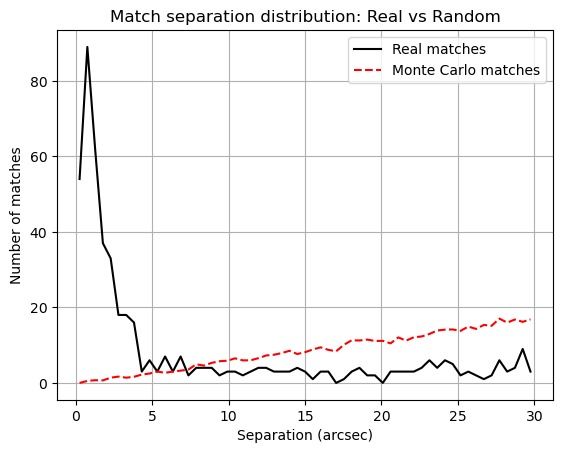

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.stats import binned_statistic


with fits.open(Source_dir+"Catalogues\\"+crossmatching_catalogue) as catalogue_hdul:
    catalogue_table = Table(catalogue_hdul[1].data)

SAMI_Target_catalogues = ("InputCatClustersDR3.fits", "InputCatFiller.fits", "InputCatGAMADR3.fits")
with fits.open(Source_dir+"Catalogues\\"+SAMI_Target_catalogues[2]) as SAMI_hdul:
    SAMI_table = Table(SAMI_hdul[1].data)

# STEP 1: Load real data (RA/Dec arrays for radio and optical)
radio_ra, radio_dec = SAMI_table['RA_OBJ'], SAMI_table['DEC_OBJ']  # e.g., FIRST
catalogue_ra, catalogue_dec = catalogue_table['RA'], catalogue_table['Dec']  # e.g., SDSS or GAMA

radio_coords = SkyCoord(radio_ra, radio_dec, unit='deg')
optical_coords = SkyCoord(catalogue_ra, catalogue_dec, unit='deg')

# STEP 2: Find real nearest neighbor match separations
idx, sep2d, _ = radio_coords.match_to_catalog_sky(optical_coords)
real_separations = sep2d.arcsec

# STEP 3: Generate a Monte Carlo (random-shifted) catalog
n_trials = 100
all_random_separations = []

for i in range(n_trials):
    # Randomly shift optical positions by a few arcmin
    ra_shift = np.random.uniform(-0.1, 0.1, size=len(catalogue_ra))  # degrees
    dec_shift = np.random.uniform(-0.1, 0.1, size=len(catalogue_dec))

    shifted_ra = (catalogue_ra + ra_shift)%360
    shifted_dec = np.mod((catalogue_dec + dec_shift) +90, 180) -90

    shifted_coords = SkyCoord(shifted_ra, shifted_dec, unit='deg')
    
    # Match again to radio
    idx_rand, sep2d_rand, _ = radio_coords.match_to_catalog_sky(shifted_coords)
    all_random_separations.append(sep2d_rand.arcsec)

# STEP 4: Histogram comparison
bins = np.linspace(0, 30, 60)

real_hist, _ = np.histogram(real_separations, bins=bins)
rand_hist_avg = np.mean([np.histogram(seps, bins=bins)[0] for seps in all_random_separations], axis=0)

# Normalize random histogram to same scale (optional)
real_area = np.sum(real_hist)
rand_area = np.sum(rand_hist_avg)
rand_hist_scaled = rand_hist_avg * (real_area / rand_area)

# STEP 5: Plot
bin_centers = 0.5 * (bins[1:] + bins[:-1])

plt.plot(bin_centers, real_hist, label="Real matches", color='black')
plt.plot(bin_centers, rand_hist_scaled, label="Monte Carlo matches", color='red', linestyle='--')
plt.xlabel("Separation (arcsec)")
plt.ylabel("Number of matches")
plt.legend()
plt.grid(True)
plt.title("Match separation distribution: Real vs Random")
plt.show()


AttributeError: 'Axes' object has no attribute 'flatten'

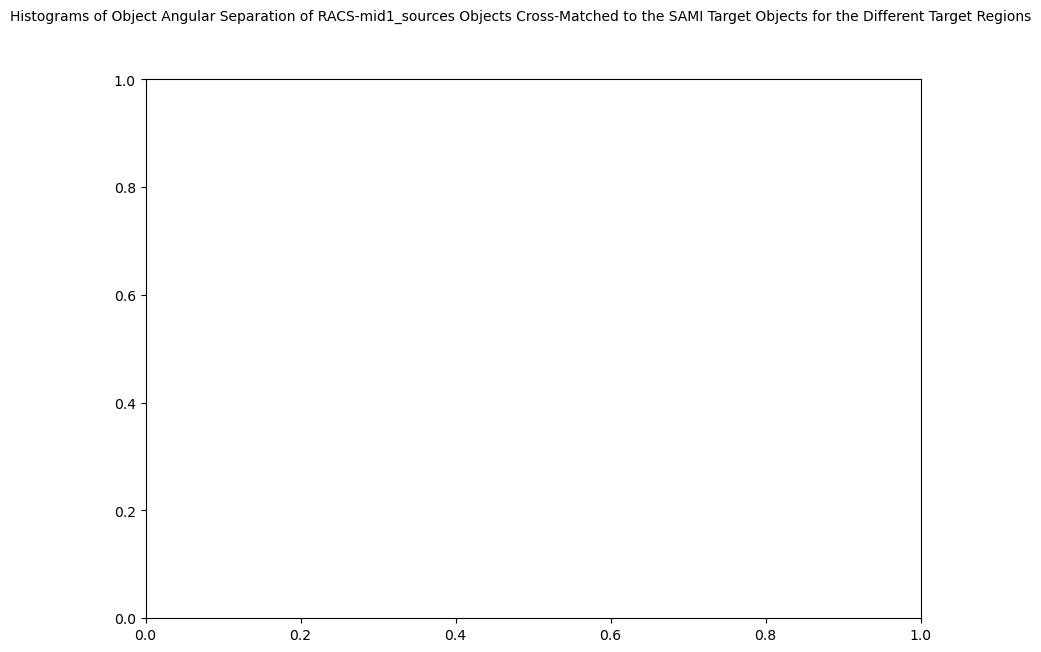

In [27]:


for i, crossmatching_catalogue in enumerate(crossmatching_catalogues[:1]):    
    height, width = 7, 10
    fig1, axs1 = plt.subplots(1, 1)
    fig1.set_figheight(height)
    fig1.set_figwidth(width)
    fig1.suptitle(f'Histograms of Object Angular Separation of {crossmatching_catalogue[:-5]} Objects Cross-Matched to the SAMI Target Objects for the Different Target Regions', fontsize=10)

    crossmatched_filename = f"all_SAMI_target_matched_{crossmatching_catalogue}"
    crossmatched_filepath = fits_filepath+"Crossmatched\\"+crossmatched_filename

    with fits.open(crossmatched_filepath) as crossmatched_hdul:
        crossmatched_table_hdu = Table(crossmatched_hdul[1].data)

        separation_array = np.array(crossmatched_table_hdu['separation'])
        region_ls = crossmatched_table_hdu['SAMI_region']
        sep_regions = [0,0,0]

    for j, region in enumerate(SAMI_regions):    
        region_separation_array = separation_array[region_ls==region]
        sep_regions[j] = region_separation_array

        ax = axs1.flatten()[j]
        nbins = 20
        ax.hist(region_separation_array, bins = nbins)
        ax.set_title(f"Target Object Region: {region}")
        ax.legend()
        ax.set_xlabel('Angular separation')
        ax.set_ylabel('Number of Matches')

    ax = axs1.flatten()[3]
    nbins = 20
    ax.hist(sep_regions, bins = nbins, stacked=True, density=True, label=SAMI_regions)
    ax.set_title(f"All Regions")
    ax.legend()
    ax.set_xlabel('Angular separation')
    ax.set_ylabel('Number of Matches')


In [123]:
refresh_module()

fits_filename = "RACS-mid1_sources.fits"
fits_filepath = Source_dir+"Catalogues\\"

test_crossmatch1 = all_fctns.get_all_SAMI_crossmatched_fits_table(fits_filepath, fits_filename, sep_arcsec=20, save_file=False)
test_crossmatch1



CATID,RA_OBJ,DEC_OBJ,r_petro,r_auto,z_spec,M_r,r_e,mu_within_1re,mu_1re,mu_2re,ellip,PA_1,g_i,Mstar,R_on_rtwo,V_on_sigma,is_mem,SURV_SAMI,BAD_CLASS,Name,Source_ID,Field_ID,RA,Dec,Dec_corr,E_RA,E_Dec,E_Dec_corr,Total_flux,E_Total_flux_PyBDSF,E_Total_flux,Peak_flux,E_Peak_flux_PyBDSF,E_Peak_flux,Maj_axis,Min_axis,PA_2,E_Maj_axis,E_Min_axis,E_PA,DC_Maj_axis,DC_Min_axis,DC_PA,E_DC_Maj_axis,E_DC_Min_axis,E_DC_PA,Noise,Tile_l,Tile_m,Tile_sep,Gal_lon,Gal_lat,PSF_Maj,PSF_Min,PSF_PA,S_Code,N_Gaussians,Flag,Scan_start_MJD,Scan_length,SBID,E_Flux_scale,sep_arcsec,SAMI_region,FILLFLAG,PA,RA_IFU,DEC_IFU,z_tonry,A_g
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,arcsec,,,,,,,
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,str26,str17,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,int64,int64,float64,float64,int64,float64,float64,str8,int16,float64,float64,float64,float32,float32
9011900001,14.0671544540651,-1.25536934215829,12.986222,13.169163,0.04452117,-23.33175,63.775894,22.915201,24.42576,25.986717,0.20853871,217.45499,1.3198166,11.5877,6.697878e-06,0.11110196,1,7,0,RACS-MID1 J005616.1-011519,RACS_0104+00_2997,RACS_0104+00,14.06718177564679,-1.2551630531547162,-1.2552167623880706,0.00026948262743965647,0.00018749562541214135,0.00019376536923058866,1.413556069584681,0.478546627245479,0.48600430161750446,1.5217227542473215,0.28823961446573765,0.3023547252057022,11.015864911899003,9.115224587087342,99.37399519817312,2.2993488480503266,1.5668136694177648,44.319037724876296,0.0,0.0,0.0,2.2993488480503266,1.5668136694177648,44.319037724876296,0.29586488381028175,-2.051889867945027,-1.2554314393160908,2.4054854248151596,125.69710544181031,-64.10097090752917,10.8,10.0,52.5,S,1,0,59231.35049387106,915.70175984314,21453,0.06,0.7491224039333537,Clusters,--,--,--,--,--,--
9011900026,14.102856099287,-1.27846422839776,17.45619,16.57982,0.03740503,-19.914854,3.164202,21.195738,22.227749,23.880344,0.29454967,245.385,1.1572647,10.112734,0.065412894,-2.3296893,1,7,0,RACS-MID1 J005624.8-011701,RACS_0042+00_68,RACS_0042+00,14.103170429205115,-1.283635080335322,-1.2836889021583164,0.0006054164361338677,0.00024983470158387264,0.00025457620362448046,1547.6699779526461,36.334824935115854,99.71577609098229,54.584634945077816,1.0052181314677,3.425872156305032,175.1785197828166,42.33041929757299,18.96265205561197,5.412541497831094,1.2372731014530727,2.51820086261594,174.85936673787245,41.06653552882443,18.947372852148558,5.412541497831094,1.2372731014530727,2.51820086261594,1.0052181314677,3.3563418498262707,-1.2843696595275704,3.5936939262005523,125.78228469043617,-64.12784688638025,10.8,10.0,52.83,M,15,1,59427.86250795104,905.748479394226,29581,0.06,18.649412033892858,Clusters,--,--,--,--,--,--
9011900026,14.102856099287,-1.27846422839776,17.45619,16.57982,0.03740503,-19.914854,3.164202,21.195738,22.227749,23.880344,0.29454967,245.385,1.1572647,10.112734,0.065412894,-2.3296893,1,7,0,RACS-MID1 J005625.4-011633,RACS_0104+00_2963,RACS_0104+00,14.10563804428718,-1.2758541642287264,-1.2759079552963668,0.0004967994360662103,0.00024830194021356464,0.00025307147734314825,939.4369379397674,20.536990901276273,59.990985427774326,56.49812257818813,0.9770789183676243,3.5278916494436645,128.854159002842,39.25909289933395,22.532348416797344,4.526413506100219,1.2959424052238597,2.95046396980778,128.41698274426815,37.90687340818462,22.504920782585476,4.526413506100219,1.2959424052238597,2.95046396980778,0.9770789183676243,-2.0134290436216524,-1.2761168435765942,2.383772370038539,125.78714195318797,-64.1199643087524,10.8,10.0,52.5,M,15,1,59231.35049387106,915.70175984314,21453,0.06,13.73097207225757,Clusters,--,--,--,--,--,--
9011900027

# Redone crossmatching fctns

In [179]:

def get_crossmatched_fits_table(catalogue_filepath, 
                                SAMI_target_table, 
                                survey_cutout_table_hdu, 
                                sep_arcsec = 20, 
                                crossmatching_colnames = ('RA', 'Dec'), 
                                save_file = False, 
                                only_closest = False,
                                SAMI_cols_to_keep = ('CATID', 'RA_OBJ', 'DEC_OBJ'),
                                survey_cols_to_keep = 'ALL'):
    """
    Returns and Saves a crossmatched catalogue of a SAMI_Target_catalogue and the desired crossmatching_catalogue when separation of objects is less than sep_arcsec.
    """

    max_separation = sep_arcsec*u.arcsec #max distance to be considered a match in arcsec

    SAMI_RA_array = np.array(SAMI_target_table['RA_OBJ'])
    SAMI_Dec_array = np.array(SAMI_target_table['DEC_OBJ'])

    SAMI_coords = SkyCoord(SAMI_RA_array, SAMI_Dec_array, unit='deg')
    
    survey_cutout_RA_array = np.array(survey_cutout_table_hdu[crossmatching_colnames[0]])
    survey_cutout_Dec_array = np.array(survey_cutout_table_hdu[crossmatching_colnames[1]])

    survey_cutout_coords = SkyCoord(survey_cutout_RA_array, survey_cutout_Dec_array, unit='deg')


    # initialise reduced version of SAMI default is keeping only CATID, RA_OBJ and DEC_OBJ columns
    reduced_SAMI_target_table = SAMI_target_table.copy()    
    if not SAMI_cols_to_keep == 'ALL':
        reduced_SAMI_target_table.keep_columns(SAMI_cols_to_keep)

    # now initialise a reduced version of the matching catalogue default is to keep all columns
    reduced_survey_cutout_table_hdu = survey_cutout_table_hdu.copy()
    if not survey_cols_to_keep == 'ALL':
        reduced_survey_cutout_table_hdu.keep_columns(survey_cols_to_keep)


    # now, do crossmatching with Skycoord
    matched_indices, separation, _ = SAMI_coords.match_to_catalog_sky(survey_cutout_coords)
    
    
    survey_cutout_matched_table = reduced_survey_cutout_table_hdu[matched_indices]

    crossmatched_table = astropy.table.hstack([reduced_SAMI_target_table, survey_cutout_matched_table, Table([separation.arcsec], names=['sep_arcsec'])])
    reduced_crossmatched_table = crossmatched_table[crossmatched_table['sep_arcsec']*u.arcsec<=max_separation]

    # ensure only closest match is kept in table
    if only_closest:
        sorted_reduced_crossmatched_table = reduced_crossmatched_table[reduced_crossmatched_table.argsort('sep_arcsec')]
        sep_sorted_survey_RA = sorted_reduced_crossmatched_table[crossmatching_colnames[0]]
        unique_sep_sorted_survey_RA, unique_index = np.unique(sep_sorted_survey_RA, return_index = True)

        reduced_crossmatched_table= sorted_reduced_crossmatched_table[unique_index]



    if save_file:
        crossmatched_filename = f"{SAMI_Target_catalogue[:-5]}_matched_{crossmatching_catalogue}"

        crossmatched_filepath = catalogue_filepath+"Crossmatched\\"+crossmatched_filename
        reduced_crossmatched_table.write(crossmatched_filepath)
        print(f"Crossmatched Table Saved to: {crossmatched_filepath}")

    return reduced_crossmatched_table

def get_all_SAMI_crossmatched_fits_table(catalogue_filepath, 
                                crossmatching_catalogue, 
                                sep_arcsec = 20, 
                                crossmatching_colnames = ('RA', 'Dec'), 
                                separation_column = True, 
                                save_file = False, 
                                only_closest = True,
                                SAMI_cols_to_keep = ('CATID', 'RA_OBJ', 'DEC_OBJ'),
                                survey_cols_to_keep = 'ALL'):
    
    SAMI_Target_catalogues = ("InputCatClustersDR3.fits", "InputCatFiller.fits", "InputCatGAMADR3.fits")
    SAMI_regions = ("Clusters", "Filler", "GAMA")


    # test if the combined SAMI target catalogue exists
    try: 
        with fits.open(catalogue_filepath + "ALL_SAMI_TARGETS.fits") as all_SAMI_targets_hdul:
            None
    except FileNotFoundError: # if not, produce one
        print("All SAMI Targets Catalogue does not already exist.")
        get_all_SAMI_targets_catalogue(catalogue_filepath)


    # test if a cutout of the survey exists
    try:
        with fits.open(catalogue_filepath + "SAMI_target_region_cutout_" + crossmatching_catalogue) as survey_cutout_hdul:
            None
    except FileNotFoundError: # if not, produce one
        print("SAMI Target Region Cutout does not already exist.")
        get_fits_table_SAMI_target_regions_cutout(catalogue_filepath, crossmatching_catalogue, col_names=crossmatching_colnames)

    with fits.open(catalogue_filepath + "ALL_SAMI_TARGETS.fits") as all_SAMI_targets_hdul, fits.open(catalogue_filepath + "SAMI_target_region_cutout_" + crossmatching_catalogue) as survey_cutout_hdul:
        all_SAMI_target_table = Table(all_SAMI_targets_hdul[1].data)
        survey_cutout_table_hdu = Table(survey_cutout_hdul[1].data)

    all_SAMI_crossmatched_table = get_crossmatched_fits_table2(catalogue_filepath, 
                                                        all_SAMI_target_table, 
                                                        survey_cutout_table_hdu, 
                                                        save_file=False, 
                                                        sep_arcsec=sep_arcsec,
                                                        only_closest = only_closest,
                                                        crossmatching_colnames=crossmatching_colnames, 
                                                        SAMI_cols_to_keep = SAMI_cols_to_keep,
                                                        survey_cols_to_keep = survey_cols_to_keep)

    if save_file:
        crossmatched_filename = f"all_SAMI_target_matched_{crossmatching_catalogue}"

        crossmatched_filepath = catalogue_filepath+"Crossmatched\\"+crossmatched_filename
        all_SAMI_crossmatched_table.write(crossmatched_filepath)
        print(f"Crossmatched Table Saved to: {crossmatched_filepath}")


    return all_SAMI_crossmatched_table

def get_all_SAMI_targets_catalogue(catalogue_filepath, save_file = False):
    SAMI_Target_catalogues = ("InputCatClustersDR3.fits", "InputCatFiller.fits", "InputCatGAMADR3.fits")
    SAMI_regions = ("Clusters", "Filler", "GAMA")

    SAMI_tables = []
    for k, SAMI_Target_catalogue in enumerate(SAMI_Target_catalogues):
        with fits.open(catalogue_filepath + SAMI_Target_catalogue) as SAMI_Target_hdul:
            SAMI_Target_table_hdu = Table(SAMI_Target_hdul[1].data)

        SAMI_Target_table_hdu.add_column(astropy.table.Column([SAMI_regions[k]]*len(SAMI_Target_table_hdu), name='SAMI_region'))

        SAMI_tables.append(SAMI_Target_table_hdu)

    all_SAMI_Targets_table = astropy.table.vstack(SAMI_tables)


    if save_file:
        all_SAMI_Targets_table_filename = f"ALL_SAMI_TARGETS.fits"

        all_SAMI_Targets_fpath = catalogue_filepath+all_SAMI_Targets_table_filename
        all_SAMI_Targets_table.write(all_SAMI_Targets_fpath)
        print(f"Combine SAMI Targets Table Saved to: {all_SAMI_Targets_fpath}")

    return all_SAMI_Targets_table

fits_filename = "RACS-mid1_sources.fits"
fits_filepath = Source_dir+"Catalogues\\"

test_crossmatch2 = get_all_SAMI_crossmatched_fits_table(fits_filepath, fits_filename, sep_arcsec=20, save_file=False, only_closest=True)
test_crossmatch2


CATID,RA_OBJ,DEC_OBJ,Name,Source_ID,Field_ID,RA,Dec,Dec_corr,E_RA,E_Dec,E_Dec_corr,Total_flux,E_Total_flux_PyBDSF,E_Total_flux,Peak_flux,E_Peak_flux_PyBDSF,E_Peak_flux,Maj_axis,Min_axis,PA,E_Maj_axis,E_Min_axis,E_PA,DC_Maj_axis,DC_Min_axis,DC_PA,E_DC_Maj_axis,E_DC_Min_axis,E_DC_PA,Noise,Tile_l,Tile_m,Tile_sep,Gal_lon,Gal_lat,PSF_Maj,PSF_Min,PSF_PA,S_Code,N_Gaussians,Flag,Scan_start_MJD,Scan_length,SBID,E_Flux_scale,sep_arcsec
int64,float64,float64,str26,str17,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,int64,int64,float64,float64,int64,float64,float64
9044200999,5.4792542,-33.2804985,RACS-MID1 J002155.0-331652,RACS_0012-32_965,RACS_0012-32,5.47900803530835,-33.281133244061415,-33.28122791606581,0.00026491637189614894,9.318664790956359e-05,0.00019711227585383082,5.730683009979624,0.8733516607890479,0.9385998845845428,2.5226104078022447,0.16938238695729524,0.22715461866697503,24.534151339311087,9.412175504215686,14.679258111882262,2.3316553633217176,0.48064053837139786,4.8535714090969355,22.725820143271726,0.0,15.317286179674966,2.3316553633217176,0.48064053837139786,4.8535714090969355,0.16938238695729524,1.9858186020716326,-0.6918388951696569,2.102882920469552,347.1554207284717,-81.14283343535149,11.400000000000002,9.199999999999998,113.89,M,4,1,59220.41381163114,905.7484803479,20910,0.06,2.4021744621564007
9044200147,6.1329665,-33.0879364,RACS-MID1 J002431.9-330517,RACS_0012-32_635,RACS_0012-32,6.133001860025605,-33.08793478700892,-33.08802972611498,7.113750301105086e-05,0.00010163093060513312,0.0002001956735483823,3.6918560313828293,0.3412918029853741,0.40687513837571276,2.6439658901187815,0.15592309616048303,0.22243653516783837,13.529882354882407,10.834497134216038,164.55105275862735,0.8759407796655455,0.5820192259576282,10.473473082329203,0.0,0.0,0.0,0.8759407796655455,0.5820192259576282,10.473473082329203,0.1477858459111303,2.5379452414160997,-0.5126422624303635,2.5892022203095015,345.6023369651445,-81.67493223290087,11.400000000000002,9.199999999999998,113.89,S,1,1,59220.41381163114,905.7484803479,20910,0.06,0.10681091334619837
9044200061,6.2697597,-33.1035461,RACS-MID1 J002504.7-330613,RACS_0037-32_3575,RACS_0037-32,6.269477141718634,-33.103512517162414,-33.10360743496323,0.00011244329592705006,8.421350356478395e-05,0.00019202882082522293,2.4496315850119195,0.3164511511360706,0.34891808881681813,2.3633410113773707,0.17594891451923933,0.2259765279189592,12.092203524234838,8.999546172369174,120.53713523889941,1.03939199421943,0.5803192807754185,13.417311725457681,4.131040115563642,0.0,130.9979184613339,1.03939199421943,0.5803192807754185,13.417311725457681,0.17726997612044215,-2.5469664940623584,-0.5284904239067278,2.601219031538298,344.97117720302526,-81.74588527440379,11.400000000000002,9.199999999999998,113.91,S,1,0,59220.42763563113,895.795199898987,20911,0.06,0.8606354106671932
9044200188,6.5992751,-33.2288246,RACS-MID1 J002623.8-331344,RACS_0012-32_425,RACS_0012-32,6.599110116586952,-33.228794282830755,-33.22888902781148,0.00025960216747298616,0.00024130869370301978,0.00029712812670149214,0.9550373550267699,0.311832007171521,0.31705322511339795,0.8526528779597434,0.16676826227016894,0.1744388553323679,11.07137418131985,10.62447905135479,99.67801894561656,2.2046374093712444,2.041052365496089,178.1188112578546,0.0,0.0,0.0,2.2046374093712444,2.041052365496089,178.1188112578546,0.1625472796149552,2.923605350873934,-0.6655255589213802,2.9983983253123867,342.9733359964949,-81.8488241279283,11.400000000000002,9.199999999999998,113.89,S,1,0,59220.41381163114,905.7484803479,20910,0.06,0.5086712744012896
9044200305,6.7954707,-32.8635597,RACS-MID1 J002710.9-325148,RACS_0037-32_3323,RACS_0037-32,6.795359023608419,-32.86345558998069,-32.86355083159545,2.829412675051292e-05,2.6024822807276082e-05,0.00017

In [177]:

refresh_module()

fits_filename = "RACS-mid1_sources.fits"
fits_filepath = Source_dir+"Catalogues\\"

test_crossmatch2 = all_fctns.get_all_SAMI_crossmatched_fits_table(fits_filepath, fits_filename, sep_arcsec=20, save_file=False, only_closest=True)
test_crossmatch2


CATID,RA_OBJ,DEC_OBJ,Name,Source_ID,Field_ID,RA,Dec,Dec_corr,E_RA,E_Dec,E_Dec_corr,Total_flux,E_Total_flux_PyBDSF,E_Total_flux,Peak_flux,E_Peak_flux_PyBDSF,E_Peak_flux,Maj_axis,Min_axis,PA,E_Maj_axis,E_Min_axis,E_PA,DC_Maj_axis,DC_Min_axis,DC_PA,E_DC_Maj_axis,E_DC_Min_axis,E_DC_PA,Noise,Tile_l,Tile_m,Tile_sep,Gal_lon,Gal_lat,PSF_Maj,PSF_Min,PSF_PA,S_Code,N_Gaussians,Flag,Scan_start_MJD,Scan_length,SBID,E_Flux_scale,sep_arcsec
int64,float64,float64,str26,str17,str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,int64,int64,float64,float64,int64,float64,float64
9044200999,5.4792542,-33.2804985,RACS-MID1 J002155.0-331652,RACS_0012-32_965,RACS_0012-32,5.47900803530835,-33.281133244061415,-33.28122791606581,0.00026491637189614894,9.318664790956359e-05,0.00019711227585383082,5.730683009979624,0.8733516607890479,0.9385998845845428,2.5226104078022447,0.16938238695729524,0.22715461866697503,24.534151339311087,9.412175504215686,14.679258111882262,2.3316553633217176,0.48064053837139786,4.8535714090969355,22.725820143271726,0.0,15.317286179674966,2.3316553633217176,0.48064053837139786,4.8535714090969355,0.16938238695729524,1.9858186020716326,-0.6918388951696569,2.102882920469552,347.1554207284717,-81.14283343535149,11.400000000000002,9.199999999999998,113.89,M,4,1,59220.41381163114,905.7484803479,20910,0.06,2.4021744621564007
9044200147,6.1329665,-33.0879364,RACS-MID1 J002431.9-330517,RACS_0012-32_635,RACS_0012-32,6.133001860025605,-33.08793478700892,-33.08802972611498,7.113750301105086e-05,0.00010163093060513312,0.0002001956735483823,3.6918560313828293,0.3412918029853741,0.40687513837571276,2.6439658901187815,0.15592309616048303,0.22243653516783837,13.529882354882407,10.834497134216038,164.55105275862735,0.8759407796655455,0.5820192259576282,10.473473082329203,0.0,0.0,0.0,0.8759407796655455,0.5820192259576282,10.473473082329203,0.1477858459111303,2.5379452414160997,-0.5126422624303635,2.5892022203095015,345.6023369651445,-81.67493223290087,11.400000000000002,9.199999999999998,113.89,S,1,1,59220.41381163114,905.7484803479,20910,0.06,0.10681091334619837
9044200061,6.2697597,-33.1035461,RACS-MID1 J002504.7-330613,RACS_0037-32_3575,RACS_0037-32,6.269477141718634,-33.103512517162414,-33.10360743496323,0.00011244329592705006,8.421350356478395e-05,0.00019202882082522293,2.4496315850119195,0.3164511511360706,0.34891808881681813,2.3633410113773707,0.17594891451923933,0.2259765279189592,12.092203524234838,8.999546172369174,120.53713523889941,1.03939199421943,0.5803192807754185,13.417311725457681,4.131040115563642,0.0,130.9979184613339,1.03939199421943,0.5803192807754185,13.417311725457681,0.17726997612044215,-2.5469664940623584,-0.5284904239067278,2.601219031538298,344.97117720302526,-81.74588527440379,11.400000000000002,9.199999999999998,113.91,S,1,0,59220.42763563113,895.795199898987,20911,0.06,0.8606354106671932
9044200188,6.5992751,-33.2288246,RACS-MID1 J002623.8-331344,RACS_0012-32_425,RACS_0012-32,6.599110116586952,-33.228794282830755,-33.22888902781148,0.00025960216747298616,0.00024130869370301978,0.00029712812670149214,0.9550373550267699,0.311832007171521,0.31705322511339795,0.8526528779597434,0.16676826227016894,0.1744388553323679,11.07137418131985,10.62447905135479,99.67801894561656,2.2046374093712444,2.041052365496089,178.1188112578546,0.0,0.0,0.0,2.2046374093712444,2.041052365496089,178.1188112578546,0.1625472796149552,2.923605350873934,-0.6655255589213802,2.9983983253123867,342.9733359964949,-81.8488241279283,11.400000000000002,9.199999999999998,113.89,S,1,0,59220.41381163114,905.7484803479,20910,0.06,0.5086712744012896
9044200305,6.7954707,-32.8635597,RACS-MID1 J002710.9-325148,RACS_0037-32_3323,RACS_0037-32,6.795359023608419,-32.86345558998069,-32.86355083159545,2.829412675051292e-05,2.6024822807276082e-05,0.00017

In [173]:
refresh_module()

all_fctns.get_all_SAMI_targets_catalogue(Source_dir+"Catalogues\\")


CATID,RA_OBJ,DEC_OBJ,r_petro,r_auto,z_spec,M_r,r_e,mu_within_1re,mu_1re,mu_2re,ellip,PA,g_i,Mstar,R_on_rtwo,V_on_sigma,is_mem,SURV_SAMI,BAD_CLASS,SAMI_region,FILLFLAG,RA_IFU,DEC_IFU,z_tonry,A_g
int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,int16,str8,int16,float64,float64,float32,float32
9011900001,14.0671544540651,-1.25536934215829,12.986222,13.169163,0.04452117,-23.33175,63.775894,22.915201,24.42576,25.986717,0.20853871,217.45499,1.3198166,11.5877,6.697878e-06,0.11110196,1,7,0,Clusters,--,--,--,--,--
9011900002,14.0740338479429,-1.26032983309023,16.286343,16.306042,0.03911899,-20.190361,1.387755,19.107248,20.176815,21.818083,0.072153755,275.84613,1.1202059,10.15713,0.01305153,-1.7402956,1,7,8,Clusters,--,--,--,--,--
9011900003,14.0745767980926,-1.26213395249889,15.871767,16.268087,0.03849665,-20.227768,nan,nan,nan,nan,nan,nan,1.1498327,10.205531,0.015452894,-1.9541932,1,7,0,Clusters,--,--,--,--,--
9011900005,14.0537852533633,-1.26329011523927,18.609417,17.308725,0.03778281,-19.185982,nan,nan,nan,nan,nan,nan,1.262867,9.887663,0.023897447,-2.199696,1,7,0,Clusters,--,--,--,--,--
9011900006,14.0756150589043,-1.24184017010364,15.212702,15.001332,0.04361263,-21.498928,2.6059005,19.021425,20.363825,21.946754,0.052937705,169.88126,1.2993641,10.841409,0.024552945,-0.19959885,1,7,0,Clusters,--,--,--,--,--
9011900007,14.0846572063946,-1.25063438254069,17.997269,18.026249,0.04105724,-18.47185,27.696348,24.935598,26.68287,28.223352,0.42923176,107.90984,1.1796379,9.530834,0.027897105,-1.0749329,1,7,0,Clusters,--,--,--,--,--
9011900008,14.0556512198554,-1.27001669208809,15.944301,15.723641,0.045318015,-20.778236,2.1965058,19.245888,20.680416,22.25035,0.099254526,232.4183,1.213438,10.474614,0.028646763,0.38338172,1,7,8,Clusters,--,--,--,--,--
9011900009,14.0534865822132,-1.26942390078162,15.902063,15.652073,0.045034066,-20.849602,2.5547311,19.301964,20.665499,22.245218,0.29823938,223.73413,1.2527571,10.533861,0.030153474,0.28638074,1,7,0,Clusters,--,--,--,--,--
9011900011,14.055867985949,-1.23839880327462,16.880154,16.626684,0.048625406,-19.87669,9.380324,22.387285,23.869879,25.433975,0.41189596,134.14691,1.1027069,10.014269,0.03135175,1.511288,1,7,0,Clusters,--,--,--,--,--
